In [1]:
from __future__ import print_function, division
from keras.constraints import max_norm
from keras.regularizers import l2
from custom_layers import Conv1D_linearphase
from heartnet_v1 import heartnet, reshape_folds, branch
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.4
set_session(tf.Session(config=config))
import numpy as np
np.random.seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
from keras.utils import to_categorical
from keras.optimizers import Adam, SGD
from keras.callbacks import CSVLogger, ModelCheckpoint, TensorBoard, Callback
from keras.utils import plot_model
from keras.layers import Dense, Dropout, Concatenate, initializers, Input
from keras.models import Model
from keras import backend as K
from sklearn.metrics import recall_score, confusion_matrix
import pandas as pd
import os
import tables
from datetime import datetime
from hyperopt import hp, fmin, Trials, tpe, STATUS_OK

Using TensorFlow backend.


In [2]:
def compute_weight(Y, classes):
    num_samples = (len(Y))
    n_classes = (len(classes))
    num_bin = np.sum(Y,axis=-2)
    class_weights = {i: (num_samples / (n_classes * num_bin[i])) for i in range(n_classes)}
    return class_weights

In [3]:
def heartnet_transfer(load_path='/media/taufiq/Data1/heart_sound/weights.0148-0.8902.hdf5',
                      lr=0.0012843784,lr_decay=0.0001132885,
                      num_dense1=20,num_dense2=20,trainable=False,dropout_rate=0.):
    model = heartnet(load_path=False,FIR_train=False,trainable=trainable)
    plot_model(model,'before.png',show_shapes=True,show_layer_names=True)
    x = model.layers[-4].output
    x = Dense(num_dense1,activation='relu',kernel_initializer=initializers.he_uniform(seed=1)) (x)
    x = Dropout(rate=dropout_rate,seed=1) (x)
    x = Dense(num_dense2, activation='relu',kernel_initializer=initializers.he_normal(seed=1))(x)
    x = Dropout(rate=dropout_rate, seed=1)(x)
    output = Dense(3,activation='softmax')(x)
    model = Model(inputs=model.input,outputs=output)
    plot_model(model, 'after.png',show_shapes=True,show_layer_names=True)
    if load_path:
        model.load_weights(load_path,by_name=True)
    sgd = SGD(lr=lr)
    model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [4]:
class log_UAR(Callback):

    def __init__(self, x_val, y_val, val_parts):
        self.x_val = x_val
        self.y_val = y_val
        self.val_parts = val_parts


    def on_epoch_end(self, epoch, logs):
        if logs is not None:
            y_pred = self.model.predict(self.x_val, verbose=0)
            y_pred = np.argmax(y_pred, axis=-1)
            self.y_val_ = np.transpose(np.argmax(self.y_val, axis=-1))
            true = []
            pred = []
            start_idx = 0
            for s in self.val_parts:

                if not s:  ## for e00032 in validation0 there was no cardiac cycle
                    continue
                # ~ print "part {} start {} stop {}".format(s,start_idx,start_idx+int(s)-1)

                temp_ = self.y_val_[start_idx:start_idx + int(s) - 1]
                temp = y_pred[start_idx:start_idx + int(s) - 1]

                if (sum(temp == 0) > sum(temp == 1)) and (sum(temp == 0) > sum(temp == 2)):
                    pred.append(0)
                elif (sum(temp == 2) > sum(temp == 1)) and (sum(temp == 2) > sum(temp == 0)):
                    pred.append(2)
                else:
                    pred.append(1)

                if (sum(temp_ == 0) > sum(temp_ == 1)) and (sum(temp_ == 0) > sum(temp_ == 2)):
                    true.append(0)
                elif (sum(temp_ == 2) > sum(temp_ == 1)) and (sum(temp_ == 2) > sum(temp_ == 0)):
                    true.append(2)
                else:
                    true.append(1)

                start_idx = start_idx + int(s)

            score = recall_score(y_pred=pred, y_true=true, average='macro')
            logs['UAR'] = np.array(score)

In [5]:
fold_dir = '/media/taufiq/Data1/heart_sound/feature/segmented_noFIR/'
foldname = 'comParE'
model_dir = '/media/taufiq/Data1/heart_sound/models/'
log_dir = '/media/taufiq/Data1/heart_sound/logs/'

##### Load Model ######
load_path='/media/taufiq/Data1/heart_sound/weights.0148-0.8902.hdf5'
# lr = 0.00001
# lr = 0.1
# num_dense1 = 734 #34,120,167,239,1239,650,788,422,598
# num_dense2 = 20 #121,
epochs = 20
batch_size = 256
dropout_rate = 0.
trainable = True
addweights = True

In [6]:
feat = tables.open_file(fold_dir + foldname + '.mat')
x_train = feat.root.trainX[:]
y_train = feat.root.trainY[0, :]
x_val = feat.root.valX[:]
y_val = feat.root.valY[0, :]
train_parts = feat.root.train_parts[:]
val_parts = feat.root.val_parts[0, :]
############### Reshaping ############
x_train, y_train, x_val, y_val = reshape_folds(x_train, x_val, y_train, y_val)
y_train = to_categorical(y_train,num_classes=3)
y_val = to_categorical(y_val,num_classes=3)

(17061, 2500, 1)
(17061, 1)
(5872, 2500, 1)
(5872, 1)


In [46]:
def objective(args):
    #### Parse arguments and print #####
    
    print("args %s" % args)
    
    lr = args['lr']
    num_dense1 = args['num_dense1']
    num_dense2 = args['num_dense2']
    
    ##### Load model ######
    model = heartnet_transfer(load_path=load_path,lr=lr,num_dense1=num_dense1,
                              num_dense2=num_dense2,trainable=trainable,
                              dropout_rate=dropout_rate)
    
    #### Log params #####
    log_name = foldname + ' ' + str(datetime.now()) + str(args.values())
    checkpoint_name = model_dir + log_name + "/" + 'weights.{epoch:04d}-{val_acc:.4f}.hdf5'
    if not os.path.exists(model_dir + log_name):
        os.makedirs(model_dir + log_name)
    plot_model(model,"model.png",show_layer_names=True,show_shapes=True)
    
    ### Callbacks ###
    
    csv_logger = CSVLogger(log_dir + log_name + '/training.csv')
    modelcheckpnt = ModelCheckpoint(filepath=checkpoint_name,
                                    monitor='val_acc', save_best_only=False, mode='max')
    tensbd = TensorBoard(log_dir=log_dir + log_name,
                         batch_size=batch_size,
                         # histogram_freq=100,
                         # embeddings_freq=99,
                         # embeddings_layer_names=embedding_layer_names,
                         # embeddings_data=x_val,
                         # embeddings_metadata=metadata_file,
                         write_images=False)
    class_weights=compute_weight(y_train,range(3))
    print("Class weights %s" % class_weights)

    #### Train ####
    
    history = model.fit(x_train,y_train,
                        batch_size=batch_size,
                        epochs=epochs,
                        verbose=2,
                        shuffle=True,
                        class_weight=class_weights,
                        callbacks=[modelcheckpnt,
                        log_UAR(x_val, y_val, val_parts),
                        tensbd, csv_logger],
                        validation_data=(x_val,y_val))
    print("History : %s" % history.history)
    loss = history.history['val_loss']
    print(loss)
    K.clear_session()
#     return (1.- np.float32(np.max(loss)))
    return {'loss': loss[-1], 'status': STATUS_OK}

In [8]:
# space = {
#     'lr' : 10 ** hp.uniform('lr',-6,-2),
#     'num_dense1' : 200 + hp.randint('num_dense1',2000),
#     'num_dense2' : 20 + hp.randint('num_dense2',1000)
# }
space = {
    'lr' : 10 ** hp.uniform('lr',-6,-2)
}

In [9]:
trials = Trials()
best = fmin(fn=objective,
            space=space,
            algo=tpe.suggest,
            trials=trials,
            max_evals=80)
print('best:', best)

args {'num_dense2': 996, 'num_dense1': 1746, 'lr': 2.520833488241432e-05}
Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 6s - loss: 1.4127 - acc: 0.3497 - val_loss: 1.1547 - val_acc: 0.3214
Epoch 2/45
 - 4s - loss: 1.3816 - acc: 0.3360 - val_loss: 1.1582 - val_acc: 0.3154
Epoch 3/45
 - 4s - loss: 1.3680 - acc: 0.3251 - val_loss: 1.1575 - val_acc: 0.3137
Epoch 4/45
 - 4s - loss: 1.3611 - acc: 0.3307 - val_loss: 1.1557 - val_acc: 0.3139
Epoch 5/45
 - 4s - loss: 1.3368 - acc: 0.3336 - val_loss: 1.1567 - val_acc: 0.3116
Epoch 6/45
 - 4s - loss: 1.3268 - acc: 0.3400 - val_loss: 1.1554 - val_acc: 0.3122
Epoch 7/45
 - 4s - loss: 1.3195 - acc: 0.3361 - val_loss: 1.1557 - val_acc: 0.3152
Epoch 8/45
 - 4s - loss: 1.3145 - acc: 0.3396 - val_loss: 1.1559 - val_acc: 0.3161
Epoch 9/45
 - 4s - loss: 1.3092 - acc: 0.3386 - val_loss: 1.1570 - val_acc: 0.3145
Epoch 10/45
 - 5s - loss: 1.2973 - acc: 0.3439

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.3464 - acc: 0.3443 - val_loss: 1.1819 - val_acc: 0.3149
Epoch 2/45
 - 5s - loss: 1.3177 - acc: 0.3407 - val_loss: 1.1744 - val_acc: 0.3188
Epoch 3/45
 - 5s - loss: 1.3026 - acc: 0.3411 - val_loss: 1.1711 - val_acc: 0.3210
Epoch 4/45
 - 5s - loss: 1.2847 - acc: 0.3527 - val_loss: 1.1683 - val_acc: 0.3258
Epoch 5/45
 - 5s - loss: 1.2713 - acc: 0.3555 - val_loss: 1.1705 - val_acc: 0.3214
Epoch 6/45
 - 5s - loss: 1.2553 - acc: 0.3561 - val_loss: 1.1646 - val_acc: 0.3248
Epoch 7/45
 - 5s - loss: 1.2535 - acc: 0.3611 - val_loss: 1.1646 - val_acc: 0.3244
Epoch 8/45
 - 5s - loss: 1.2370 - acc: 0.3656 - val_loss: 1.1644 - val_acc: 0.3254
Epoch 9/45
 - 5s - loss: 1.2214 - acc: 0.3785 - val_loss: 1.1656 - val_acc: 0.3263
Epoch 10/45
 - 5s - loss: 1.2174 - acc: 0.3781 - val_loss: 1.1623 - val_acc: 0.3273
Epoch 11/45
 - 5s - loss: 1.2073 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.2589 - acc: 0.4099 - val_loss: 1.2050 - val_acc: 0.3556
Epoch 2/45
 - 4s - loss: 1.0242 - acc: 0.4843 - val_loss: 1.1715 - val_acc: 0.3386
Epoch 3/45
 - 4s - loss: 0.9646 - acc: 0.5275 - val_loss: 1.2139 - val_acc: 0.3413
Epoch 4/45
 - 4s - loss: 0.9293 - acc: 0.5490 - val_loss: 1.1662 - val_acc: 0.3554
Epoch 5/45
 - 5s - loss: 0.8925 - acc: 0.5695 - val_loss: 1.1480 - val_acc: 0.3931
Epoch 6/45
 - 4s - loss: 0.8663 - acc: 0.5904 - val_loss: 1.2088 - val_acc: 0.3440
Epoch 7/45
 - 5s - loss: 0.8414 - acc: 0.5970 - val_loss: 1.2481 - val_acc: 0.3018
Epoch 8/45
 - 4s - loss: 0.8195 - acc: 0.6144 - val_loss: 1.2496 - val_acc: 0.3345
Epoch 9/45
 - 5s - loss: 0.7903 - acc: 0.6337 - val_loss: 1.2199 - val_acc: 0.3457
Epoch 10/45
 - 4s - loss: 0.7656 - acc: 0.6429 - val_loss: 1.1869 - val_acc: 0.3697
Epoch 11/45
 - 4s - loss: 0.7523 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.9478 - acc: 0.5365 - val_loss: 1.1704 - val_acc: 0.5017
Epoch 2/45
 - 4s - loss: 1.8826 - acc: 0.5351 - val_loss: 1.1590 - val_acc: 0.4968
Epoch 3/45
 - 4s - loss: 1.7922 - acc: 0.5265 - val_loss: 1.1499 - val_acc: 0.4925
Epoch 4/45
 - 4s - loss: 1.7585 - acc: 0.5174 - val_loss: 1.1429 - val_acc: 0.4869
Epoch 5/45
 - 5s - loss: 1.7040 - acc: 0.5153 - val_loss: 1.1378 - val_acc: 0.4819
Epoch 6/45
 - 5s - loss: 1.6625 - acc: 0.5135 - val_loss: 1.1338 - val_acc: 0.4733
Epoch 7/45
 - 5s - loss: 1.6173 - acc: 0.5062 - val_loss: 1.1314 - val_acc: 0.4649
Epoch 8/45
 - 5s - loss: 1.5781 - acc: 0.4904 - val_loss: 1.1304 - val_acc: 0.4557
Epoch 9/45
 - 5s - loss: 1.5516 - acc: 0.4864 - val_loss: 1.1301 - val_acc: 0.4443
Epoch 10/45
 - 5s - loss: 1.5308 - acc: 0.4787 - val_loss: 1.1305 - val_acc: 0.4366
Epoch 11/45
 - 5s - loss: 1.5068 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.2684 - acc: 0.3656 - val_loss: 1.1575 - val_acc: 0.3794
Epoch 2/45
 - 5s - loss: 1.1435 - acc: 0.4170 - val_loss: 1.1596 - val_acc: 0.3607
Epoch 3/45
 - 5s - loss: 1.0856 - acc: 0.4446 - val_loss: 1.1693 - val_acc: 0.3546
Epoch 4/45
 - 5s - loss: 1.0590 - acc: 0.4659 - val_loss: 1.1584 - val_acc: 0.3541
Epoch 5/45
 - 5s - loss: 1.0292 - acc: 0.4813 - val_loss: 1.1759 - val_acc: 0.3486
Epoch 6/45
 - 5s - loss: 1.0061 - acc: 0.4912 - val_loss: 1.1749 - val_acc: 0.3450
Epoch 7/45
 - 5s - loss: 0.9961 - acc: 0.5009 - val_loss: 1.1836 - val_acc: 0.3481
Epoch 8/45
 - 5s - loss: 0.9741 - acc: 0.5132 - val_loss: 1.2004 - val_acc: 0.3306
Epoch 9/45
 - 5s - loss: 0.9650 - acc: 0.5239 - val_loss: 1.2056 - val_acc: 0.3334
Epoch 10/45
 - 5s - loss: 0.9537 - acc: 0.5304 - val_loss: 1.1888 - val_acc: 0.3362
Epoch 11/45
 - 5s - loss: 0.9437 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 1.5902 - acc: 0.3022 - val_loss: 1.2817 - val_acc: 0.3435
Epoch 2/45
 - 4s - loss: 1.5500 - acc: 0.3052 - val_loss: 1.2640 - val_acc: 0.3459
Epoch 3/45
 - 4s - loss: 1.5161 - acc: 0.3107 - val_loss: 1.2486 - val_acc: 0.3527
Epoch 4/45
 - 4s - loss: 1.4891 - acc: 0.3151 - val_loss: 1.2365 - val_acc: 0.3544
Epoch 5/45
 - 4s - loss: 1.4604 - acc: 0.3151 - val_loss: 1.2257 - val_acc: 0.3561
Epoch 6/45
 - 4s - loss: 1.4539 - acc: 0.3225 - val_loss: 1.2162 - val_acc: 0.3627
Epoch 7/45
 - 4s - loss: 1.4337 - acc: 0.3196 - val_loss: 1.2084 - val_acc: 0.3667
Epoch 8/45
 - 4s - loss: 1.4242 - acc: 0.3187 - val_loss: 1.2014 - val_acc: 0.3718
Epoch 9/45
 - 4s - loss: 1.4057 - acc: 0.3221 - val_loss: 1.1957 - val_acc: 0.3735
Epoch 10/45
 - 4s - loss: 1.4138 - acc: 0.3211 - val_loss: 1.1909 - val_acc: 0.3781
Epoch 11/45
 - 4s - loss: 1.4000 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 1.6699 - acc: 0.3542 - val_loss: 1.3852 - val_acc: 0.3474
Epoch 2/45
 - 4s - loss: 1.6384 - acc: 0.3541 - val_loss: 1.3713 - val_acc: 0.3537
Epoch 3/45
 - 4s - loss: 1.6162 - acc: 0.3609 - val_loss: 1.3580 - val_acc: 0.3573
Epoch 4/45
 - 4s - loss: 1.6039 - acc: 0.3614 - val_loss: 1.3455 - val_acc: 0.3573
Epoch 5/45
 - 4s - loss: 1.5805 - acc: 0.3647 - val_loss: 1.3354 - val_acc: 0.3607
Epoch 6/45
 - 4s - loss: 1.5562 - acc: 0.3653 - val_loss: 1.3261 - val_acc: 0.3598
Epoch 7/45
 - 4s - loss: 1.5377 - acc: 0.3662 - val_loss: 1.3175 - val_acc: 0.3563
Epoch 8/45
 - 4s - loss: 1.5286 - acc: 0.3633 - val_loss: 1.3099 - val_acc: 0.3558
Epoch 9/45
 - 4s - loss: 1.5071 - acc: 0.3703 - val_loss: 1.3031 - val_acc: 0.3564
Epoch 10/45
 - 4s - loss: 1.5055 - acc: 0.3716 - val_loss: 1.2974 - val_acc: 0.3563
Epoch 11/45
 - 4s - loss: 1.4915 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 1.8625 - acc: 0.3723 - val_loss: 1.2978 - val_acc: 0.2962
Epoch 2/45
 - 4s - loss: 1.7124 - acc: 0.3689 - val_loss: 1.2639 - val_acc: 0.2885
Epoch 3/45
 - 4s - loss: 1.6136 - acc: 0.3589 - val_loss: 1.2431 - val_acc: 0.2853
Epoch 4/45
 - 4s - loss: 1.5189 - acc: 0.3599 - val_loss: 1.2338 - val_acc: 0.2815
Epoch 5/45
 - 4s - loss: 1.4432 - acc: 0.3553 - val_loss: 1.2321 - val_acc: 0.2737
Epoch 6/45
 - 4s - loss: 1.4008 - acc: 0.3502 - val_loss: 1.2358 - val_acc: 0.2742
Epoch 7/45
 - 4s - loss: 1.3780 - acc: 0.3511 - val_loss: 1.2424 - val_acc: 0.2730
Epoch 8/45
 - 4s - loss: 1.3577 - acc: 0.3540 - val_loss: 1.2490 - val_acc: 0.2745
Epoch 9/45
 - 4s - loss: 1.3314 - acc: 0.3543 - val_loss: 1.2546 - val_acc: 0.2762
Epoch 10/45
 - 4s - loss: 1.3327 - acc: 0.3517 - val_loss: 1.2598 - val_acc: 0.2757
Epoch 11/45
 - 4s - loss: 1.3329 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 1.3632 - acc: 0.3279 - val_loss: 1.1691 - val_acc: 0.3660
Epoch 2/45
 - 4s - loss: 1.2463 - acc: 0.3618 - val_loss: 1.1654 - val_acc: 0.3682
Epoch 3/45
 - 4s - loss: 1.1783 - acc: 0.3947 - val_loss: 1.1629 - val_acc: 0.3743
Epoch 4/45
 - 4s - loss: 1.1443 - acc: 0.4108 - val_loss: 1.1694 - val_acc: 0.3685
Epoch 5/45
 - 4s - loss: 1.1180 - acc: 0.4200 - val_loss: 1.1684 - val_acc: 0.3639
Epoch 6/45
 - 4s - loss: 1.1030 - acc: 0.4289 - val_loss: 1.1610 - val_acc: 0.3736
Epoch 7/45
 - 4s - loss: 1.0770 - acc: 0.4455 - val_loss: 1.1733 - val_acc: 0.3593
Epoch 8/45
 - 4s - loss: 1.0667 - acc: 0.4499 - val_loss: 1.1713 - val_acc: 0.3558
Epoch 9/45
 - 4s - loss: 1.0530 - acc: 0.4548 - val_loss: 1.1697 - val_acc: 0.3624
Epoch 10/45
 - 4s - loss: 1.0441 - acc: 0.4609 - val_loss: 1.1702 - val_acc: 0.3593
Epoch 11/45
 - 4s - loss: 1.0392 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.6344 - acc: 0.2090 - val_loss: 1.4593 - val_acc: 0.2178
Epoch 2/45
 - 5s - loss: 1.5974 - acc: 0.2132 - val_loss: 1.4388 - val_acc: 0.2210
Epoch 3/45
 - 5s - loss: 1.5831 - acc: 0.2200 - val_loss: 1.4207 - val_acc: 0.2253
Epoch 4/45
 - 5s - loss: 1.5671 - acc: 0.2237 - val_loss: 1.4038 - val_acc: 0.2277
Epoch 5/45
 - 5s - loss: 1.5454 - acc: 0.2301 - val_loss: 1.3880 - val_acc: 0.2321
Epoch 6/45
 - 5s - loss: 1.5331 - acc: 0.2350 - val_loss: 1.3743 - val_acc: 0.2362
Epoch 7/45
 - 5s - loss: 1.5147 - acc: 0.2354 - val_loss: 1.3606 - val_acc: 0.2365
Epoch 8/45
 - 5s - loss: 1.5089 - acc: 0.2427 - val_loss: 1.3484 - val_acc: 0.2382
Epoch 9/45
 - 5s - loss: 1.4943 - acc: 0.2469 - val_loss: 1.3371 - val_acc: 0.2398
Epoch 10/45
 - 5s - loss: 1.4905 - acc: 0.2509 - val_loss: 1.3266 - val_acc: 0.2417
Epoch 11/45
 - 5s - loss: 1.4757 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.4578 - acc: 0.2439 - val_loss: 1.3161 - val_acc: 0.2428
Epoch 2/45
 - 5s - loss: 1.4278 - acc: 0.2586 - val_loss: 1.2992 - val_acc: 0.2491
Epoch 3/45
 - 5s - loss: 1.4175 - acc: 0.2592 - val_loss: 1.2853 - val_acc: 0.2573
Epoch 4/45
 - 5s - loss: 1.4099 - acc: 0.2696 - val_loss: 1.2727 - val_acc: 0.2618
Epoch 5/45
 - 5s - loss: 1.3970 - acc: 0.2747 - val_loss: 1.2611 - val_acc: 0.2694
Epoch 6/45
 - 5s - loss: 1.3854 - acc: 0.2830 - val_loss: 1.2521 - val_acc: 0.2749
Epoch 7/45
 - 5s - loss: 1.3748 - acc: 0.2905 - val_loss: 1.2437 - val_acc: 0.2822
Epoch 8/45
 - 5s - loss: 1.3627 - acc: 0.2966 - val_loss: 1.2361 - val_acc: 0.2885
Epoch 9/45
 - 5s - loss: 1.3694 - acc: 0.2966 - val_loss: 1.2300 - val_acc: 0.2938
Epoch 10/45
 - 5s - loss: 1.3641 - acc: 0.3055 - val_loss: 1.2246 - val_acc: 0.3006
Epoch 11/45
 - 5s - loss: 1.3657 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 2.1612 - acc: 0.2596 - val_loss: 1.7867 - val_acc: 0.2600
Epoch 2/45
 - 5s - loss: 2.1196 - acc: 0.2549 - val_loss: 1.7538 - val_acc: 0.2566
Epoch 3/45
 - 4s - loss: 2.0431 - acc: 0.2584 - val_loss: 1.7241 - val_acc: 0.2537
Epoch 4/45
 - 5s - loss: 2.0216 - acc: 0.2525 - val_loss: 1.6964 - val_acc: 0.2502
Epoch 5/45
 - 5s - loss: 1.9702 - acc: 0.2483 - val_loss: 1.6697 - val_acc: 0.2476
Epoch 6/45
 - 4s - loss: 1.9168 - acc: 0.2487 - val_loss: 1.6448 - val_acc: 0.2442
Epoch 7/45
 - 5s - loss: 1.8937 - acc: 0.2437 - val_loss: 1.6206 - val_acc: 0.2413
Epoch 8/45
 - 5s - loss: 1.8480 - acc: 0.2449 - val_loss: 1.5981 - val_acc: 0.2401
Epoch 9/45
 - 5s - loss: 1.8149 - acc: 0.2450 - val_loss: 1.5758 - val_acc: 0.2389
Epoch 10/45
 - 5s - loss: 1.7987 - acc: 0.2421 - val_loss: 1.5557 - val_acc: 0.2359
Epoch 11/45
 - 5s - loss: 1.7574 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 1.4441 - acc: 0.3791 - val_loss: 1.2153 - val_acc: 0.3225
Epoch 2/45
 - 4s - loss: 1.3847 - acc: 0.3493 - val_loss: 1.2226 - val_acc: 0.3060
Epoch 3/45
 - 4s - loss: 1.3708 - acc: 0.3435 - val_loss: 1.2195 - val_acc: 0.3023
Epoch 4/45
 - 4s - loss: 1.3487 - acc: 0.3505 - val_loss: 1.2106 - val_acc: 0.3045
Epoch 5/45
 - 4s - loss: 1.3454 - acc: 0.3534 - val_loss: 1.2074 - val_acc: 0.3033
Epoch 6/45
 - 4s - loss: 1.3192 - acc: 0.3612 - val_loss: 1.2014 - val_acc: 0.3089
Epoch 7/45
 - 4s - loss: 1.3131 - acc: 0.3614 - val_loss: 1.2019 - val_acc: 0.3074
Epoch 8/45
 - 4s - loss: 1.3036 - acc: 0.3629 - val_loss: 1.1979 - val_acc: 0.3096
Epoch 9/45
 - 4s - loss: 1.2926 - acc: 0.3700 - val_loss: 1.1971 - val_acc: 0.3074
Epoch 10/45
 - 4s - loss: 1.2775 - acc: 0.3732 - val_loss: 1.1925 - val_acc: 0.3111
Epoch 11/45
 - 4s - loss: 1.2651 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.3367 - acc: 0.3624 - val_loss: 1.1293 - val_acc: 0.3886
Epoch 2/45
 - 5s - loss: 1.2748 - acc: 0.3663 - val_loss: 1.1371 - val_acc: 0.3762
Epoch 3/45
 - 5s - loss: 1.2454 - acc: 0.3765 - val_loss: 1.1486 - val_acc: 0.3745
Epoch 4/45
 - 5s - loss: 1.2235 - acc: 0.3849 - val_loss: 1.1393 - val_acc: 0.3811
Epoch 5/45
 - 5s - loss: 1.2079 - acc: 0.3893 - val_loss: 1.1449 - val_acc: 0.3811
Epoch 6/45
 - 4s - loss: 1.1792 - acc: 0.4033 - val_loss: 1.1585 - val_acc: 0.3690
Epoch 7/45
 - 5s - loss: 1.1710 - acc: 0.4063 - val_loss: 1.1704 - val_acc: 0.3704
Epoch 8/45
 - 5s - loss: 1.1549 - acc: 0.4161 - val_loss: 1.1587 - val_acc: 0.3730
Epoch 9/45
 - 4s - loss: 1.1462 - acc: 0.4242 - val_loss: 1.1799 - val_acc: 0.3612
Epoch 10/45
 - 4s - loss: 1.1356 - acc: 0.4262 - val_loss: 1.1724 - val_acc: 0.3694
Epoch 11/45
 - 5s - loss: 1.1252 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.7996 - acc: 0.4077 - val_loss: 1.3263 - val_acc: 0.3561
Epoch 2/45
 - 5s - loss: 1.6166 - acc: 0.4152 - val_loss: 1.2776 - val_acc: 0.3638
Epoch 3/45
 - 5s - loss: 1.4837 - acc: 0.4110 - val_loss: 1.2561 - val_acc: 0.3556
Epoch 4/45
 - 5s - loss: 1.4082 - acc: 0.4043 - val_loss: 1.2498 - val_acc: 0.3411
Epoch 5/45
 - 5s - loss: 1.3603 - acc: 0.3896 - val_loss: 1.2491 - val_acc: 0.3283
Epoch 6/45
 - 5s - loss: 1.3537 - acc: 0.3832 - val_loss: 1.2497 - val_acc: 0.3183
Epoch 7/45
 - 5s - loss: 1.3330 - acc: 0.3725 - val_loss: 1.2516 - val_acc: 0.3096
Epoch 8/45
 - 5s - loss: 1.3296 - acc: 0.3673 - val_loss: 1.2539 - val_acc: 0.3084
Epoch 9/45
 - 5s - loss: 1.3133 - acc: 0.3674 - val_loss: 1.2541 - val_acc: 0.3053
Epoch 10/45
 - 5s - loss: 1.3161 - acc: 0.3604 - val_loss: 1.2554 - val_acc: 0.3001
Epoch 11/45
 - 5s - loss: 1.3248 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.3410 - acc: 0.3588 - val_loss: 1.2263 - val_acc: 0.2881
Epoch 2/45
 - 4s - loss: 1.2527 - acc: 0.3652 - val_loss: 1.2193 - val_acc: 0.3030
Epoch 3/45
 - 4s - loss: 1.1943 - acc: 0.3857 - val_loss: 1.2195 - val_acc: 0.2989
Epoch 4/45
 - 5s - loss: 1.1690 - acc: 0.3962 - val_loss: 1.2086 - val_acc: 0.3082
Epoch 5/45
 - 4s - loss: 1.1404 - acc: 0.4068 - val_loss: 1.2155 - val_acc: 0.3033
Epoch 6/45
 - 5s - loss: 1.1231 - acc: 0.4138 - val_loss: 1.2150 - val_acc: 0.3072
Epoch 7/45
 - 4s - loss: 1.1066 - acc: 0.4248 - val_loss: 1.2008 - val_acc: 0.3140
Epoch 8/45
 - 4s - loss: 1.0849 - acc: 0.4374 - val_loss: 1.2044 - val_acc: 0.3195
Epoch 9/45
 - 5s - loss: 1.0700 - acc: 0.4457 - val_loss: 1.2026 - val_acc: 0.3156
Epoch 10/45
 - 5s - loss: 1.0622 - acc: 0.4484 - val_loss: 1.1992 - val_acc: 0.3139
Epoch 11/45
 - 5s - loss: 1.0634 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.3266 - acc: 0.3532 - val_loss: 1.1649 - val_acc: 0.3270
Epoch 2/45
 - 5s - loss: 1.2610 - acc: 0.3745 - val_loss: 1.1647 - val_acc: 0.3438
Epoch 3/45
 - 5s - loss: 1.2086 - acc: 0.3915 - val_loss: 1.1737 - val_acc: 0.3416
Epoch 4/45
 - 5s - loss: 1.1767 - acc: 0.4010 - val_loss: 1.1960 - val_acc: 0.3191
Epoch 5/45
 - 5s - loss: 1.1487 - acc: 0.4194 - val_loss: 1.1948 - val_acc: 0.3336
Epoch 6/45
 - 5s - loss: 1.1398 - acc: 0.4213 - val_loss: 1.1969 - val_acc: 0.3317
Epoch 7/45
 - 5s - loss: 1.1188 - acc: 0.4315 - val_loss: 1.2013 - val_acc: 0.3334
Epoch 8/45
 - 5s - loss: 1.1008 - acc: 0.4356 - val_loss: 1.2085 - val_acc: 0.3285
Epoch 9/45
 - 5s - loss: 1.0892 - acc: 0.4464 - val_loss: 1.2061 - val_acc: 0.3338
Epoch 10/45
 - 5s - loss: 1.0684 - acc: 0.4564 - val_loss: 1.2068 - val_acc: 0.3341
Epoch 11/45
 - 5s - loss: 1.0641 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 1.6282 - acc: 0.4591 - val_loss: 1.1612 - val_acc: 0.3939
Epoch 2/45
 - 4s - loss: 1.4601 - acc: 0.3958 - val_loss: 1.1839 - val_acc: 0.3382
Epoch 3/45
 - 4s - loss: 1.4117 - acc: 0.3663 - val_loss: 1.2012 - val_acc: 0.3118
Epoch 4/45
 - 4s - loss: 1.3987 - acc: 0.3490 - val_loss: 1.2092 - val_acc: 0.3036
Epoch 5/45
 - 4s - loss: 1.3791 - acc: 0.3494 - val_loss: 1.2113 - val_acc: 0.3014
Epoch 6/45
 - 4s - loss: 1.3760 - acc: 0.3484 - val_loss: 1.2107 - val_acc: 0.3026
Epoch 7/45
 - 4s - loss: 1.3609 - acc: 0.3503 - val_loss: 1.2112 - val_acc: 0.3016
Epoch 8/45
 - 4s - loss: 1.3557 - acc: 0.3519 - val_loss: 1.2093 - val_acc: 0.3006
Epoch 9/45
 - 4s - loss: 1.3480 - acc: 0.3523 - val_loss: 1.2073 - val_acc: 0.3001
Epoch 10/45
 - 4s - loss: 1.3206 - acc: 0.3512 - val_loss: 1.2057 - val_acc: 0.3035
Epoch 11/45
 - 4s - loss: 1.3229 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 1.4414 - acc: 0.3353 - val_loss: 1.1615 - val_acc: 0.3723
Epoch 2/45
 - 4s - loss: 1.4228 - acc: 0.3363 - val_loss: 1.1508 - val_acc: 0.3813
Epoch 3/45
 - 4s - loss: 1.4063 - acc: 0.3388 - val_loss: 1.1429 - val_acc: 0.3849
Epoch 4/45
 - 4s - loss: 1.3862 - acc: 0.3376 - val_loss: 1.1376 - val_acc: 0.3874
Epoch 5/45
 - 4s - loss: 1.3751 - acc: 0.3353 - val_loss: 1.1338 - val_acc: 0.3878
Epoch 6/45
 - 4s - loss: 1.3738 - acc: 0.3455 - val_loss: 1.1312 - val_acc: 0.3869
Epoch 7/45
 - 4s - loss: 1.3630 - acc: 0.3368 - val_loss: 1.1291 - val_acc: 0.3888
Epoch 8/45
 - 5s - loss: 1.3661 - acc: 0.3390 - val_loss: 1.1280 - val_acc: 0.3920
Epoch 9/45
 - 4s - loss: 1.3595 - acc: 0.3371 - val_loss: 1.1269 - val_acc: 0.3915
Epoch 10/45
 - 4s - loss: 1.3439 - acc: 0.3434 - val_loss: 1.1263 - val_acc: 0.3907
Epoch 11/45
 - 4s - loss: 1.3513 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 1.2496 - acc: 0.3489 - val_loss: 1.1622 - val_acc: 0.3404
Epoch 2/45
 - 4s - loss: 1.1329 - acc: 0.4078 - val_loss: 1.1811 - val_acc: 0.3297
Epoch 3/45
 - 4s - loss: 1.0854 - acc: 0.4387 - val_loss: 1.1790 - val_acc: 0.3403
Epoch 4/45
 - 4s - loss: 1.0596 - acc: 0.4560 - val_loss: 1.1774 - val_acc: 0.3345
Epoch 5/45
 - 4s - loss: 1.0333 - acc: 0.4678 - val_loss: 1.1910 - val_acc: 0.3418
Epoch 6/45
 - 4s - loss: 1.0130 - acc: 0.4850 - val_loss: 1.1807 - val_acc: 0.3357
Epoch 7/45
 - 4s - loss: 0.9925 - acc: 0.4953 - val_loss: 1.1926 - val_acc: 0.3263
Epoch 8/45
 - 4s - loss: 0.9816 - acc: 0.5073 - val_loss: 1.1837 - val_acc: 0.3435
Epoch 9/45
 - 4s - loss: 0.9740 - acc: 0.5129 - val_loss: 1.1811 - val_acc: 0.3314
Epoch 10/45
 - 4s - loss: 0.9638 - acc: 0.5198 - val_loss: 1.1805 - val_acc: 0.3411
Epoch 11/45
 - 4s - loss: 0.9448 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.4089 - acc: 0.3697 - val_loss: 1.1325 - val_acc: 0.3886
Epoch 2/45
 - 5s - loss: 1.4060 - acc: 0.3668 - val_loss: 1.1346 - val_acc: 0.3868
Epoch 3/45
 - 5s - loss: 1.3939 - acc: 0.3636 - val_loss: 1.1366 - val_acc: 0.3850
Epoch 4/45
 - 5s - loss: 1.3931 - acc: 0.3695 - val_loss: 1.1383 - val_acc: 0.3837
Epoch 5/45
 - 5s - loss: 1.3840 - acc: 0.3657 - val_loss: 1.1399 - val_acc: 0.3833
Epoch 6/45
 - 5s - loss: 1.3964 - acc: 0.3551 - val_loss: 1.1412 - val_acc: 0.3815
Epoch 7/45
 - 5s - loss: 1.3871 - acc: 0.3591 - val_loss: 1.1419 - val_acc: 0.3813
Epoch 8/45
 - 5s - loss: 1.3950 - acc: 0.3571 - val_loss: 1.1427 - val_acc: 0.3808
Epoch 9/45
 - 5s - loss: 1.3762 - acc: 0.3580 - val_loss: 1.1439 - val_acc: 0.3786
Epoch 10/45
 - 5s - loss: 1.3721 - acc: 0.3526 - val_loss: 1.1447 - val_acc: 0.3787
Epoch 11/45
 - 5s - loss: 1.3807 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 2.5380 - acc: 0.1748 - val_loss: 1.7765 - val_acc: 0.1945
Epoch 2/45
 - 4s - loss: 2.4783 - acc: 0.1753 - val_loss: 1.7431 - val_acc: 0.1945
Epoch 3/45
 - 4s - loss: 2.4199 - acc: 0.1762 - val_loss: 1.7133 - val_acc: 0.1960
Epoch 4/45
 - 4s - loss: 2.3643 - acc: 0.1778 - val_loss: 1.6836 - val_acc: 0.1967
Epoch 5/45
 - 4s - loss: 2.3124 - acc: 0.1789 - val_loss: 1.6550 - val_acc: 0.1982
Epoch 6/45
 - 4s - loss: 2.2628 - acc: 0.1808 - val_loss: 1.6290 - val_acc: 0.2003
Epoch 7/45
 - 4s - loss: 2.2092 - acc: 0.1817 - val_loss: 1.6036 - val_acc: 0.2016
Epoch 8/45
 - 4s - loss: 2.1598 - acc: 0.1857 - val_loss: 1.5792 - val_acc: 0.2030
Epoch 9/45
 - 4s - loss: 2.1118 - acc: 0.1881 - val_loss: 1.5553 - val_acc: 0.2033
Epoch 10/45
 - 4s - loss: 2.0635 - acc: 0.1867 - val_loss: 1.5329 - val_acc: 0.2042
Epoch 11/45
 - 4s - loss: 2.0486 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 2.2650 - acc: 0.5459 - val_loss: 1.2100 - val_acc: 0.5121
Epoch 2/45
 - 5s - loss: 2.0131 - acc: 0.5375 - val_loss: 1.1617 - val_acc: 0.5037
Epoch 3/45
 - 5s - loss: 1.8003 - acc: 0.5270 - val_loss: 1.1356 - val_acc: 0.4889
Epoch 4/45
 - 5s - loss: 1.6707 - acc: 0.5059 - val_loss: 1.1233 - val_acc: 0.4710
Epoch 5/45
 - 5s - loss: 1.5622 - acc: 0.4934 - val_loss: 1.1209 - val_acc: 0.4464
Epoch 6/45
 - 5s - loss: 1.4948 - acc: 0.4684 - val_loss: 1.1244 - val_acc: 0.4205
Epoch 7/45
 - 5s - loss: 1.4504 - acc: 0.4534 - val_loss: 1.1308 - val_acc: 0.3963
Epoch 8/45
 - 5s - loss: 1.4111 - acc: 0.4378 - val_loss: 1.1387 - val_acc: 0.3748
Epoch 9/45
 - 5s - loss: 1.3851 - acc: 0.4303 - val_loss: 1.1463 - val_acc: 0.3585
Epoch 10/45
 - 5s - loss: 1.3844 - acc: 0.4143 - val_loss: 1.1534 - val_acc: 0.3437
Epoch 11/45
 - 5s - loss: 1.3640 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 1.4719 - acc: 0.3972 - val_loss: 1.2329 - val_acc: 0.3450
Epoch 2/45
 - 4s - loss: 1.4300 - acc: 0.3798 - val_loss: 1.2364 - val_acc: 0.3273
Epoch 3/45
 - 4s - loss: 1.3917 - acc: 0.3663 - val_loss: 1.2401 - val_acc: 0.3198
Epoch 4/45
 - 4s - loss: 1.3731 - acc: 0.3580 - val_loss: 1.2442 - val_acc: 0.3118
Epoch 5/45
 - 4s - loss: 1.3710 - acc: 0.3428 - val_loss: 1.2467 - val_acc: 0.3048
Epoch 6/45
 - 4s - loss: 1.3615 - acc: 0.3382 - val_loss: 1.2482 - val_acc: 0.2985
Epoch 7/45
 - 4s - loss: 1.3451 - acc: 0.3402 - val_loss: 1.2494 - val_acc: 0.2956
Epoch 8/45
 - 5s - loss: 1.3452 - acc: 0.3327 - val_loss: 1.2502 - val_acc: 0.2924
Epoch 9/45
 - 4s - loss: 1.3390 - acc: 0.3391 - val_loss: 1.2497 - val_acc: 0.2927
Epoch 10/45
 - 4s - loss: 1.3365 - acc: 0.3322 - val_loss: 1.2492 - val_acc: 0.2917
Epoch 11/45
 - 4s - loss: 1.3276 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 1.4359 - acc: 0.3348 - val_loss: 1.1490 - val_acc: 0.3706
Epoch 2/45
 - 4s - loss: 1.3846 - acc: 0.3417 - val_loss: 1.1479 - val_acc: 0.3714
Epoch 3/45
 - 4s - loss: 1.3594 - acc: 0.3519 - val_loss: 1.1484 - val_acc: 0.3704
Epoch 4/45
 - 4s - loss: 1.3515 - acc: 0.3530 - val_loss: 1.1482 - val_acc: 0.3707
Epoch 5/45
 - 4s - loss: 1.3376 - acc: 0.3607 - val_loss: 1.1476 - val_acc: 0.3721
Epoch 6/45
 - 4s - loss: 1.3422 - acc: 0.3666 - val_loss: 1.1458 - val_acc: 0.3724
Epoch 7/45
 - 4s - loss: 1.3222 - acc: 0.3659 - val_loss: 1.1467 - val_acc: 0.3709
Epoch 8/45
 - 4s - loss: 1.3026 - acc: 0.3693 - val_loss: 1.1453 - val_acc: 0.3719
Epoch 9/45
 - 4s - loss: 1.3030 - acc: 0.3690 - val_loss: 1.1453 - val_acc: 0.3731
Epoch 10/45
 - 4s - loss: 1.2882 - acc: 0.3714 - val_loss: 1.1466 - val_acc: 0.3694
Epoch 11/45
 - 4s - loss: 1.2875 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 1.7456 - acc: 0.2122 - val_loss: 1.4267 - val_acc: 0.2141
Epoch 2/45
 - 4s - loss: 1.7174 - acc: 0.2116 - val_loss: 1.4125 - val_acc: 0.2163
Epoch 3/45
 - 4s - loss: 1.6896 - acc: 0.2183 - val_loss: 1.3984 - val_acc: 0.2217
Epoch 4/45
 - 4s - loss: 1.6775 - acc: 0.2192 - val_loss: 1.3864 - val_acc: 0.2251
Epoch 5/45
 - 4s - loss: 1.6500 - acc: 0.2323 - val_loss: 1.3739 - val_acc: 0.2289
Epoch 6/45
 - 4s - loss: 1.6320 - acc: 0.2318 - val_loss: 1.3632 - val_acc: 0.2345
Epoch 7/45
 - 4s - loss: 1.6175 - acc: 0.2326 - val_loss: 1.3521 - val_acc: 0.2376
Epoch 8/45
 - 4s - loss: 1.5989 - acc: 0.2362 - val_loss: 1.3421 - val_acc: 0.2440
Epoch 9/45
 - 4s - loss: 1.5821 - acc: 0.2421 - val_loss: 1.3335 - val_acc: 0.2463
Epoch 10/45
 - 4s - loss: 1.5650 - acc: 0.2460 - val_loss: 1.3246 - val_acc: 0.2502
Epoch 11/45
 - 4s - loss: 1.5457 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.5541 - acc: 0.2325 - val_loss: 1.3490 - val_acc: 0.2347
Epoch 2/45
 - 5s - loss: 1.5009 - acc: 0.2486 - val_loss: 1.3188 - val_acc: 0.2469
Epoch 3/45
 - 5s - loss: 1.4566 - acc: 0.2644 - val_loss: 1.2963 - val_acc: 0.2573
Epoch 4/45
 - 5s - loss: 1.4388 - acc: 0.2747 - val_loss: 1.2780 - val_acc: 0.2674
Epoch 5/45
 - 5s - loss: 1.4210 - acc: 0.2807 - val_loss: 1.2638 - val_acc: 0.2735
Epoch 6/45
 - 5s - loss: 1.4091 - acc: 0.2939 - val_loss: 1.2528 - val_acc: 0.2829
Epoch 7/45
 - 5s - loss: 1.4006 - acc: 0.2999 - val_loss: 1.2443 - val_acc: 0.2897
Epoch 8/45
 - 5s - loss: 1.3853 - acc: 0.3055 - val_loss: 1.2373 - val_acc: 0.2985
Epoch 9/45
 - 5s - loss: 1.3816 - acc: 0.3159 - val_loss: 1.2315 - val_acc: 0.3042
Epoch 10/45
 - 5s - loss: 1.3715 - acc: 0.3191 - val_loss: 1.2272 - val_acc: 0.3088
Epoch 11/45
 - 5s - loss: 1.3691 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.5187 - acc: 0.3769 - val_loss: 1.2076 - val_acc: 0.3004
Epoch 2/45
 - 4s - loss: 1.3516 - acc: 0.3310 - val_loss: 1.2039 - val_acc: 0.3033
Epoch 3/45
 - 4s - loss: 1.3186 - acc: 0.3360 - val_loss: 1.1903 - val_acc: 0.3157
Epoch 4/45
 - 4s - loss: 1.2880 - acc: 0.3493 - val_loss: 1.1826 - val_acc: 0.3239
Epoch 5/45
 - 4s - loss: 1.2677 - acc: 0.3591 - val_loss: 1.1858 - val_acc: 0.3234
Epoch 6/45
 - 4s - loss: 1.2445 - acc: 0.3664 - val_loss: 1.1877 - val_acc: 0.3253
Epoch 7/45
 - 4s - loss: 1.2285 - acc: 0.3739 - val_loss: 1.1932 - val_acc: 0.3215
Epoch 8/45
 - 4s - loss: 1.2064 - acc: 0.3824 - val_loss: 1.1898 - val_acc: 0.3292
Epoch 9/45
 - 4s - loss: 1.2004 - acc: 0.3866 - val_loss: 1.1919 - val_acc: 0.3249
Epoch 10/45
 - 4s - loss: 1.1781 - acc: 0.3996 - val_loss: 1.1885 - val_acc: 0.3282
Epoch 11/45
 - 4s - loss: 1.1850 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.7516 - acc: 0.2056 - val_loss: 1.4206 - val_acc: 0.2117
Epoch 2/45
 - 4s - loss: 1.4911 - acc: 0.2462 - val_loss: 1.3220 - val_acc: 0.2372
Epoch 3/45
 - 4s - loss: 1.4277 - acc: 0.2734 - val_loss: 1.2761 - val_acc: 0.2612
Epoch 4/45
 - 4s - loss: 1.3938 - acc: 0.3040 - val_loss: 1.2500 - val_acc: 0.2771
Epoch 5/45
 - 4s - loss: 1.3719 - acc: 0.3106 - val_loss: 1.2357 - val_acc: 0.2912
Epoch 6/45
 - 4s - loss: 1.3746 - acc: 0.3223 - val_loss: 1.2273 - val_acc: 0.2977
Epoch 7/45
 - 4s - loss: 1.3671 - acc: 0.3293 - val_loss: 1.2223 - val_acc: 0.3004
Epoch 8/45
 - 4s - loss: 1.3525 - acc: 0.3344 - val_loss: 1.2183 - val_acc: 0.3009
Epoch 9/45
 - 4s - loss: 1.3454 - acc: 0.3318 - val_loss: 1.2151 - val_acc: 0.3038
Epoch 10/45
 - 4s - loss: 1.3391 - acc: 0.3427 - val_loss: 1.2130 - val_acc: 0.3052
Epoch 11/45
 - 4s - loss: 1.3341 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.4257 - acc: 0.3540 - val_loss: 1.1518 - val_acc: 0.3367
Epoch 2/45
 - 5s - loss: 1.4135 - acc: 0.3450 - val_loss: 1.1540 - val_acc: 0.3277
Epoch 3/45
 - 5s - loss: 1.3967 - acc: 0.3390 - val_loss: 1.1560 - val_acc: 0.3232
Epoch 4/45
 - 5s - loss: 1.3911 - acc: 0.3366 - val_loss: 1.1576 - val_acc: 0.3220
Epoch 5/45
 - 5s - loss: 1.3842 - acc: 0.3290 - val_loss: 1.1582 - val_acc: 0.3190
Epoch 6/45
 - 5s - loss: 1.3629 - acc: 0.3322 - val_loss: 1.1589 - val_acc: 0.3185
Epoch 7/45
 - 5s - loss: 1.3754 - acc: 0.3286 - val_loss: 1.1596 - val_acc: 0.3168
Epoch 8/45
 - 5s - loss: 1.3691 - acc: 0.3272 - val_loss: 1.1600 - val_acc: 0.3159
Epoch 9/45
 - 5s - loss: 1.3636 - acc: 0.3282 - val_loss: 1.1594 - val_acc: 0.3162
Epoch 10/45
 - 5s - loss: 1.3722 - acc: 0.3318 - val_loss: 1.1595 - val_acc: 0.3156
Epoch 11/45
 - 5s - loss: 1.3653 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.3759 - acc: 0.3167 - val_loss: 1.1885 - val_acc: 0.3403
Epoch 2/45
 - 5s - loss: 1.3433 - acc: 0.3343 - val_loss: 1.1842 - val_acc: 0.3447
Epoch 3/45
 - 5s - loss: 1.3471 - acc: 0.3304 - val_loss: 1.1817 - val_acc: 0.3471
Epoch 4/45
 - 5s - loss: 1.3348 - acc: 0.3392 - val_loss: 1.1815 - val_acc: 0.3462
Epoch 5/45
 - 5s - loss: 1.3242 - acc: 0.3441 - val_loss: 1.1798 - val_acc: 0.3471
Epoch 6/45
 - 5s - loss: 1.3288 - acc: 0.3472 - val_loss: 1.1809 - val_acc: 0.3447
Epoch 7/45
 - 5s - loss: 1.3150 - acc: 0.3421 - val_loss: 1.1791 - val_acc: 0.3449
Epoch 8/45
 - 5s - loss: 1.3196 - acc: 0.3395 - val_loss: 1.1773 - val_acc: 0.3452
Epoch 9/45
 - 5s - loss: 1.3045 - acc: 0.3533 - val_loss: 1.1763 - val_acc: 0.3450
Epoch 10/45
 - 5s - loss: 1.2879 - acc: 0.3530 - val_loss: 1.1748 - val_acc: 0.3460
Epoch 11/45
 - 5s - loss: 1.2817 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.1122 - acc: 0.4024 - val_loss: 1.1177 - val_acc: 0.3554
Epoch 2/45
 - 5s - loss: 1.0177 - acc: 0.4733 - val_loss: 1.1262 - val_acc: 0.3816
Epoch 3/45
 - 5s - loss: 0.9767 - acc: 0.5037 - val_loss: 1.1817 - val_acc: 0.3019
Epoch 4/45
 - 5s - loss: 0.9378 - acc: 0.5350 - val_loss: 1.1320 - val_acc: 0.3740
Epoch 5/45
 - 5s - loss: 0.9104 - acc: 0.5549 - val_loss: 1.2075 - val_acc: 0.3149
Epoch 6/45
 - 5s - loss: 0.8806 - acc: 0.5721 - val_loss: 1.2107 - val_acc: 0.3185
Epoch 7/45
 - 5s - loss: 0.8577 - acc: 0.5883 - val_loss: 1.1321 - val_acc: 0.3917
Epoch 8/45
 - 5s - loss: 0.8275 - acc: 0.6088 - val_loss: 1.2298 - val_acc: 0.3125
Epoch 9/45
 - 5s - loss: 0.8150 - acc: 0.6115 - val_loss: 1.1661 - val_acc: 0.3587
Epoch 10/45
 - 5s - loss: 0.7713 - acc: 0.6384 - val_loss: 1.1900 - val_acc: 0.3672
Epoch 11/45
 - 5s - loss: 0.7571 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 1.5197 - acc: 0.3588 - val_loss: 1.1744 - val_acc: 0.3426
Epoch 2/45
 - 4s - loss: 1.3845 - acc: 0.3392 - val_loss: 1.1902 - val_acc: 0.3248
Epoch 3/45
 - 4s - loss: 1.3712 - acc: 0.3315 - val_loss: 1.1898 - val_acc: 0.3236
Epoch 4/45
 - 4s - loss: 1.3418 - acc: 0.3384 - val_loss: 1.1877 - val_acc: 0.3268
Epoch 5/45
 - 4s - loss: 1.3221 - acc: 0.3447 - val_loss: 1.1866 - val_acc: 0.3333
Epoch 6/45
 - 4s - loss: 1.2944 - acc: 0.3542 - val_loss: 1.1856 - val_acc: 0.3360
Epoch 7/45
 - 4s - loss: 1.2870 - acc: 0.3519 - val_loss: 1.1876 - val_acc: 0.3411
Epoch 8/45
 - 4s - loss: 1.2758 - acc: 0.3579 - val_loss: 1.1872 - val_acc: 0.3392
Epoch 9/45
 - 4s - loss: 1.2516 - acc: 0.3659 - val_loss: 1.1858 - val_acc: 0.3420
Epoch 10/45
 - 4s - loss: 1.2519 - acc: 0.3640 - val_loss: 1.1873 - val_acc: 0.3433
Epoch 11/45
 - 4s - loss: 1.2252 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 1.5478 - acc: 0.3708 - val_loss: 1.1955 - val_acc: 0.3564
Epoch 2/45
 - 4s - loss: 1.5267 - acc: 0.3680 - val_loss: 1.1913 - val_acc: 0.3546
Epoch 3/45
 - 4s - loss: 1.4958 - acc: 0.3696 - val_loss: 1.1881 - val_acc: 0.3534
Epoch 4/45
 - 4s - loss: 1.4868 - acc: 0.3691 - val_loss: 1.1859 - val_acc: 0.3510
Epoch 5/45
 - 4s - loss: 1.4792 - acc: 0.3594 - val_loss: 1.1839 - val_acc: 0.3506
Epoch 6/45
 - 4s - loss: 1.4602 - acc: 0.3603 - val_loss: 1.1829 - val_acc: 0.3495
Epoch 7/45
 - 4s - loss: 1.4531 - acc: 0.3578 - val_loss: 1.1823 - val_acc: 0.3483
Epoch 8/45
 - 4s - loss: 1.4451 - acc: 0.3546 - val_loss: 1.1819 - val_acc: 0.3462
Epoch 9/45
 - 4s - loss: 1.4407 - acc: 0.3588 - val_loss: 1.1821 - val_acc: 0.3459
Epoch 10/45
 - 4s - loss: 1.4248 - acc: 0.3547 - val_loss: 1.1823 - val_acc: 0.3418
Epoch 11/45
 - 4s - loss: 1.4321 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 2.2116 - acc: 0.5448 - val_loss: 1.1847 - val_acc: 0.5104
Epoch 2/45
 - 5s - loss: 2.1407 - acc: 0.5436 - val_loss: 1.1737 - val_acc: 0.5097
Epoch 3/45
 - 5s - loss: 2.0982 - acc: 0.5400 - val_loss: 1.1624 - val_acc: 0.5099
Epoch 4/45
 - 5s - loss: 2.0400 - acc: 0.5378 - val_loss: 1.1527 - val_acc: 0.5085
Epoch 5/45
 - 5s - loss: 1.9816 - acc: 0.5351 - val_loss: 1.1444 - val_acc: 0.5068
Epoch 6/45
 - 5s - loss: 1.9262 - acc: 0.5323 - val_loss: 1.1376 - val_acc: 0.5061
Epoch 7/45
 - 5s - loss: 1.8900 - acc: 0.5256 - val_loss: 1.1308 - val_acc: 0.5049
Epoch 8/45
 - 5s - loss: 1.8394 - acc: 0.5270 - val_loss: 1.1257 - val_acc: 0.5020
Epoch 9/45
 - 5s - loss: 1.8081 - acc: 0.5233 - val_loss: 1.1208 - val_acc: 0.4980
Epoch 10/45
 - 5s - loss: 1.7645 - acc: 0.5184 - val_loss: 1.1176 - val_acc: 0.4942
Epoch 11/45
 - 5s - loss: 1.7423 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.6496 - acc: 0.3595 - val_loss: 1.1791 - val_acc: 0.3661
Epoch 2/45
 - 5s - loss: 1.5672 - acc: 0.3555 - val_loss: 1.1734 - val_acc: 0.3629
Epoch 3/45
 - 5s - loss: 1.5014 - acc: 0.3485 - val_loss: 1.1723 - val_acc: 0.3646
Epoch 4/45
 - 5s - loss: 1.4594 - acc: 0.3493 - val_loss: 1.1742 - val_acc: 0.3576
Epoch 5/45
 - 5s - loss: 1.4312 - acc: 0.3450 - val_loss: 1.1788 - val_acc: 0.3466
Epoch 6/45
 - 5s - loss: 1.4149 - acc: 0.3462 - val_loss: 1.1843 - val_acc: 0.3413
Epoch 7/45
 - 5s - loss: 1.3918 - acc: 0.3449 - val_loss: 1.1895 - val_acc: 0.3382
Epoch 8/45
 - 5s - loss: 1.3803 - acc: 0.3415 - val_loss: 1.1925 - val_acc: 0.3340
Epoch 9/45
 - 5s - loss: 1.3836 - acc: 0.3424 - val_loss: 1.1962 - val_acc: 0.3348
Epoch 10/45
 - 5s - loss: 1.3807 - acc: 0.3383 - val_loss: 1.1993 - val_acc: 0.3357
Epoch 11/45
 - 5s - loss: 1.3706 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.5104 - acc: 0.2841 - val_loss: 1.1801 - val_acc: 0.3401
Epoch 2/45
 - 4s - loss: 1.3818 - acc: 0.3138 - val_loss: 1.1511 - val_acc: 0.3731
Epoch 3/45
 - 4s - loss: 1.3747 - acc: 0.3257 - val_loss: 1.1435 - val_acc: 0.3803
Epoch 4/45
 - 4s - loss: 1.3435 - acc: 0.3370 - val_loss: 1.1416 - val_acc: 0.3818
Epoch 5/45
 - 4s - loss: 1.3364 - acc: 0.3427 - val_loss: 1.1411 - val_acc: 0.3798
Epoch 6/45
 - 4s - loss: 1.3378 - acc: 0.3382 - val_loss: 1.1409 - val_acc: 0.3820
Epoch 7/45
 - 4s - loss: 1.3144 - acc: 0.3475 - val_loss: 1.1415 - val_acc: 0.3789
Epoch 8/45
 - 4s - loss: 1.3141 - acc: 0.3467 - val_loss: 1.1424 - val_acc: 0.3796
Epoch 9/45
 - 4s - loss: 1.3070 - acc: 0.3473 - val_loss: 1.1417 - val_acc: 0.3808
Epoch 10/45
 - 4s - loss: 1.2844 - acc: 0.3553 - val_loss: 1.1432 - val_acc: 0.3782
Epoch 11/45
 - 4s - loss: 1.2872 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.5196 - acc: 0.2837 - val_loss: 1.2333 - val_acc: 0.2955
Epoch 2/45
 - 4s - loss: 1.4491 - acc: 0.3081 - val_loss: 1.2181 - val_acc: 0.3052
Epoch 3/45
 - 4s - loss: 1.4199 - acc: 0.3208 - val_loss: 1.2092 - val_acc: 0.3103
Epoch 4/45
 - 4s - loss: 1.3992 - acc: 0.3304 - val_loss: 1.2054 - val_acc: 0.3135
Epoch 5/45
 - 5s - loss: 1.3870 - acc: 0.3313 - val_loss: 1.2014 - val_acc: 0.3154
Epoch 6/45
 - 4s - loss: 1.3663 - acc: 0.3449 - val_loss: 1.1999 - val_acc: 0.3151
Epoch 7/45
 - 5s - loss: 1.3689 - acc: 0.3461 - val_loss: 1.1983 - val_acc: 0.3151
Epoch 8/45
 - 5s - loss: 1.3628 - acc: 0.3444 - val_loss: 1.1969 - val_acc: 0.3145
Epoch 9/45
 - 4s - loss: 1.3571 - acc: 0.3494 - val_loss: 1.1949 - val_acc: 0.3152
Epoch 10/45
 - 4s - loss: 1.3484 - acc: 0.3476 - val_loss: 1.1926 - val_acc: 0.3176
Epoch 11/45
 - 4s - loss: 1.3383 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.6136 - acc: 0.4738 - val_loss: 1.1534 - val_acc: 0.4067
Epoch 2/45
 - 4s - loss: 1.5943 - acc: 0.4660 - val_loss: 1.1522 - val_acc: 0.3978
Epoch 3/45
 - 4s - loss: 1.5628 - acc: 0.4606 - val_loss: 1.1521 - val_acc: 0.3912
Epoch 4/45
 - 4s - loss: 1.5531 - acc: 0.4581 - val_loss: 1.1518 - val_acc: 0.3842
Epoch 5/45
 - 4s - loss: 1.5265 - acc: 0.4484 - val_loss: 1.1516 - val_acc: 0.3750
Epoch 6/45
 - 4s - loss: 1.5208 - acc: 0.4483 - val_loss: 1.1519 - val_acc: 0.3665
Epoch 7/45
 - 4s - loss: 1.5002 - acc: 0.4430 - val_loss: 1.1523 - val_acc: 0.3619
Epoch 8/45
 - 4s - loss: 1.4887 - acc: 0.4333 - val_loss: 1.1526 - val_acc: 0.3534
Epoch 9/45
 - 4s - loss: 1.4639 - acc: 0.4357 - val_loss: 1.1530 - val_acc: 0.3491
Epoch 10/45
 - 4s - loss: 1.4562 - acc: 0.4289 - val_loss: 1.1538 - val_acc: 0.3445
Epoch 11/45
 - 4s - loss: 1.4563 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.2468 - acc: 0.3860 - val_loss: 1.2005 - val_acc: 0.3549
Epoch 2/45
 - 5s - loss: 1.1087 - acc: 0.4462 - val_loss: 1.1787 - val_acc: 0.3384
Epoch 3/45
 - 5s - loss: 1.0429 - acc: 0.4804 - val_loss: 1.1955 - val_acc: 0.3249
Epoch 4/45
 - 5s - loss: 1.0116 - acc: 0.4983 - val_loss: 1.1855 - val_acc: 0.3440
Epoch 5/45
 - 5s - loss: 0.9805 - acc: 0.5108 - val_loss: 1.1724 - val_acc: 0.3483
Epoch 6/45
 - 5s - loss: 0.9529 - acc: 0.5276 - val_loss: 1.2008 - val_acc: 0.3403
Epoch 7/45
 - 5s - loss: 0.9376 - acc: 0.5390 - val_loss: 1.1921 - val_acc: 0.3392
Epoch 8/45
 - 5s - loss: 0.9189 - acc: 0.5469 - val_loss: 1.1849 - val_acc: 0.3403
Epoch 9/45
 - 5s - loss: 0.9006 - acc: 0.5593 - val_loss: 1.2107 - val_acc: 0.3316
Epoch 10/45
 - 5s - loss: 0.8871 - acc: 0.5733 - val_loss: 1.2303 - val_acc: 0.3280
Epoch 11/45
 - 5s - loss: 0.8747 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.7497 - acc: 0.2922 - val_loss: 1.2433 - val_acc: 0.2648
Epoch 2/45
 - 5s - loss: 1.7134 - acc: 0.2966 - val_loss: 1.2353 - val_acc: 0.2665
Epoch 3/45
 - 5s - loss: 1.7022 - acc: 0.2988 - val_loss: 1.2281 - val_acc: 0.2689
Epoch 4/45
 - 5s - loss: 1.6731 - acc: 0.3007 - val_loss: 1.2216 - val_acc: 0.2713
Epoch 5/45
 - 5s - loss: 1.6399 - acc: 0.3047 - val_loss: 1.2157 - val_acc: 0.2728
Epoch 6/45
 - 5s - loss: 1.6338 - acc: 0.3005 - val_loss: 1.2103 - val_acc: 0.2737
Epoch 7/45
 - 5s - loss: 1.6130 - acc: 0.3068 - val_loss: 1.2054 - val_acc: 0.2764
Epoch 8/45
 - 5s - loss: 1.5719 - acc: 0.3068 - val_loss: 1.2013 - val_acc: 0.2764
Epoch 9/45
 - 5s - loss: 1.5692 - acc: 0.3076 - val_loss: 1.1976 - val_acc: 0.2795
Epoch 10/45
 - 5s - loss: 1.5458 - acc: 0.3066 - val_loss: 1.1945 - val_acc: 0.2820
Epoch 11/45
 - 5s - loss: 1.5257 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.5304 - acc: 0.2367 - val_loss: 1.2135 - val_acc: 0.2820
Epoch 2/45
 - 4s - loss: 1.4942 - acc: 0.2538 - val_loss: 1.1941 - val_acc: 0.2929
Epoch 3/45
 - 4s - loss: 1.4676 - acc: 0.2629 - val_loss: 1.1799 - val_acc: 0.3094
Epoch 4/45
 - 4s - loss: 1.4536 - acc: 0.2730 - val_loss: 1.1702 - val_acc: 0.3215
Epoch 5/45
 - 4s - loss: 1.4395 - acc: 0.2818 - val_loss: 1.1626 - val_acc: 0.3278
Epoch 6/45
 - 4s - loss: 1.4398 - acc: 0.2905 - val_loss: 1.1579 - val_acc: 0.3336
Epoch 7/45
 - 4s - loss: 1.4310 - acc: 0.2957 - val_loss: 1.1540 - val_acc: 0.3372
Epoch 8/45
 - 4s - loss: 1.4107 - acc: 0.2985 - val_loss: 1.1506 - val_acc: 0.3435
Epoch 9/45
 - 4s - loss: 1.4162 - acc: 0.2996 - val_loss: 1.1481 - val_acc: 0.3488
Epoch 10/45
 - 4s - loss: 1.4197 - acc: 0.3026 - val_loss: 1.1465 - val_acc: 0.3512
Epoch 11/45
 - 4s - loss: 1.4155 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 2.6639 - acc: 0.5487 - val_loss: 1.2724 - val_acc: 0.5145
Epoch 2/45
 - 5s - loss: 2.2091 - acc: 0.5405 - val_loss: 1.1910 - val_acc: 0.5027
Epoch 3/45
 - 5s - loss: 1.8863 - acc: 0.5203 - val_loss: 1.1521 - val_acc: 0.4787
Epoch 4/45
 - 5s - loss: 1.6768 - acc: 0.4819 - val_loss: 1.1421 - val_acc: 0.4339
Epoch 5/45
 - 5s - loss: 1.5433 - acc: 0.4487 - val_loss: 1.1472 - val_acc: 0.3925
Epoch 6/45
 - 5s - loss: 1.4697 - acc: 0.4115 - val_loss: 1.1586 - val_acc: 0.3552
Epoch 7/45
 - 5s - loss: 1.4114 - acc: 0.4035 - val_loss: 1.1708 - val_acc: 0.3290
Epoch 8/45
 - 5s - loss: 1.3972 - acc: 0.3759 - val_loss: 1.1818 - val_acc: 0.3185
Epoch 9/45
 - 5s - loss: 1.3720 - acc: 0.3624 - val_loss: 1.1906 - val_acc: 0.3089
Epoch 10/45
 - 5s - loss: 1.3603 - acc: 0.3567 - val_loss: 1.1984 - val_acc: 0.3004
Epoch 11/45
 - 5s - loss: 1.3533 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.4797 - acc: 0.3184 - val_loss: 1.1865 - val_acc: 0.3166
Epoch 2/45
 - 5s - loss: 1.3695 - acc: 0.3221 - val_loss: 1.1820 - val_acc: 0.3251
Epoch 3/45
 - 5s - loss: 1.3227 - acc: 0.3356 - val_loss: 1.1859 - val_acc: 0.3278
Epoch 4/45
 - 5s - loss: 1.3097 - acc: 0.3431 - val_loss: 1.1901 - val_acc: 0.3253
Epoch 5/45
 - 5s - loss: 1.2681 - acc: 0.3536 - val_loss: 1.1862 - val_acc: 0.3314
Epoch 6/45
 - 5s - loss: 1.2568 - acc: 0.3684 - val_loss: 1.1898 - val_acc: 0.3302
Epoch 7/45
 - 5s - loss: 1.2384 - acc: 0.3704 - val_loss: 1.1897 - val_acc: 0.3353
Epoch 8/45
 - 5s - loss: 1.2328 - acc: 0.3705 - val_loss: 1.1921 - val_acc: 0.3418
Epoch 9/45
 - 5s - loss: 1.2147 - acc: 0.3884 - val_loss: 1.1911 - val_acc: 0.3384
Epoch 10/45
 - 5s - loss: 1.1943 - acc: 0.3989 - val_loss: 1.2034 - val_acc: 0.3345
Epoch 11/45
 - 5s - loss: 1.1896 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 1.4197 - acc: 0.2600 - val_loss: 1.2191 - val_acc: 0.2871
Epoch 2/45
 - 4s - loss: 1.3811 - acc: 0.2754 - val_loss: 1.1865 - val_acc: 0.3004
Epoch 3/45
 - 4s - loss: 1.3622 - acc: 0.2897 - val_loss: 1.1731 - val_acc: 0.3091
Epoch 4/45
 - 4s - loss: 1.3491 - acc: 0.3016 - val_loss: 1.1671 - val_acc: 0.3169
Epoch 5/45
 - 4s - loss: 1.3378 - acc: 0.3047 - val_loss: 1.1625 - val_acc: 0.3220
Epoch 6/45
 - 4s - loss: 1.3251 - acc: 0.3133 - val_loss: 1.1616 - val_acc: 0.3197
Epoch 7/45
 - 4s - loss: 1.3156 - acc: 0.3064 - val_loss: 1.1605 - val_acc: 0.3231
Epoch 8/45
 - 4s - loss: 1.3068 - acc: 0.3163 - val_loss: 1.1591 - val_acc: 0.3261
Epoch 9/45
 - 4s - loss: 1.3038 - acc: 0.3231 - val_loss: 1.1579 - val_acc: 0.3294
Epoch 10/45
 - 4s - loss: 1.2906 - acc: 0.3228 - val_loss: 1.1567 - val_acc: 0.3307
Epoch 11/45
 - 4s - loss: 1.2812 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.3895 - acc: 0.3832 - val_loss: 1.1607 - val_acc: 0.3280
Epoch 2/45
 - 5s - loss: 1.3087 - acc: 0.3604 - val_loss: 1.1695 - val_acc: 0.3249
Epoch 3/45
 - 4s - loss: 1.3086 - acc: 0.3615 - val_loss: 1.1694 - val_acc: 0.3241
Epoch 4/45
 - 4s - loss: 1.2820 - acc: 0.3770 - val_loss: 1.1700 - val_acc: 0.3237
Epoch 5/45
 - 4s - loss: 1.2718 - acc: 0.3758 - val_loss: 1.1713 - val_acc: 0.3239
Epoch 6/45
 - 5s - loss: 1.2603 - acc: 0.3676 - val_loss: 1.1682 - val_acc: 0.3268
Epoch 7/45
 - 5s - loss: 1.2494 - acc: 0.3815 - val_loss: 1.1716 - val_acc: 0.3241
Epoch 8/45
 - 4s - loss: 1.2457 - acc: 0.3839 - val_loss: 1.1753 - val_acc: 0.3217
Epoch 9/45
 - 4s - loss: 1.2302 - acc: 0.3855 - val_loss: 1.1732 - val_acc: 0.3236
Epoch 10/45
 - 5s - loss: 1.2299 - acc: 0.3908 - val_loss: 1.1747 - val_acc: 0.3239
Epoch 11/45
 - 4s - loss: 1.2159 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 1.3700 - acc: 0.3308 - val_loss: 1.1849 - val_acc: 0.3205
Epoch 2/45
 - 4s - loss: 1.3047 - acc: 0.3478 - val_loss: 1.1717 - val_acc: 0.3290
Epoch 3/45
 - 4s - loss: 1.2687 - acc: 0.3560 - val_loss: 1.1644 - val_acc: 0.3421
Epoch 4/45
 - 4s - loss: 1.2438 - acc: 0.3715 - val_loss: 1.1693 - val_acc: 0.3375
Epoch 5/45
 - 4s - loss: 1.2126 - acc: 0.3813 - val_loss: 1.1669 - val_acc: 0.3443
Epoch 6/45
 - 4s - loss: 1.1849 - acc: 0.3909 - val_loss: 1.1639 - val_acc: 0.3460
Epoch 7/45
 - 4s - loss: 1.1762 - acc: 0.4009 - val_loss: 1.1675 - val_acc: 0.3438
Epoch 8/45
 - 4s - loss: 1.1705 - acc: 0.4020 - val_loss: 1.1706 - val_acc: 0.3363
Epoch 9/45
 - 4s - loss: 1.1551 - acc: 0.4094 - val_loss: 1.1663 - val_acc: 0.3406
Epoch 10/45
 - 4s - loss: 1.1472 - acc: 0.4057 - val_loss: 1.1650 - val_acc: 0.3391
Epoch 11/45
 - 4s - loss: 1.1330 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.8326 - acc: 0.2832 - val_loss: 1.2669 - val_acc: 0.2641
Epoch 2/45
 - 5s - loss: 1.5931 - acc: 0.3177 - val_loss: 1.2036 - val_acc: 0.2956
Epoch 3/45
 - 5s - loss: 1.4520 - acc: 0.3424 - val_loss: 1.1855 - val_acc: 0.3108
Epoch 4/45
 - 5s - loss: 1.3781 - acc: 0.3469 - val_loss: 1.1860 - val_acc: 0.3130
Epoch 5/45
 - 5s - loss: 1.3331 - acc: 0.3486 - val_loss: 1.1922 - val_acc: 0.3181
Epoch 6/45
 - 5s - loss: 1.3245 - acc: 0.3469 - val_loss: 1.1986 - val_acc: 0.3164
Epoch 7/45
 - 5s - loss: 1.3143 - acc: 0.3496 - val_loss: 1.2025 - val_acc: 0.3193
Epoch 8/45
 - 5s - loss: 1.3052 - acc: 0.3513 - val_loss: 1.2058 - val_acc: 0.3191
Epoch 9/45
 - 5s - loss: 1.3060 - acc: 0.3502 - val_loss: 1.2071 - val_acc: 0.3181
Epoch 10/45
 - 5s - loss: 1.3035 - acc: 0.3455 - val_loss: 1.2076 - val_acc: 0.3181
Epoch 11/45
 - 5s - loss: 1.2905 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.4829 - acc: 0.2651 - val_loss: 1.2674 - val_acc: 0.3134
Epoch 2/45
 - 4s - loss: 1.4695 - acc: 0.2732 - val_loss: 1.2431 - val_acc: 0.3243
Epoch 3/45
 - 4s - loss: 1.4499 - acc: 0.2775 - val_loss: 1.2234 - val_acc: 0.3350
Epoch 4/45
 - 5s - loss: 1.4337 - acc: 0.2862 - val_loss: 1.2085 - val_acc: 0.3450
Epoch 5/45
 - 5s - loss: 1.4304 - acc: 0.2997 - val_loss: 1.1962 - val_acc: 0.3541
Epoch 6/45
 - 5s - loss: 1.4258 - acc: 0.3007 - val_loss: 1.1866 - val_acc: 0.3624
Epoch 7/45
 - 5s - loss: 1.4218 - acc: 0.3109 - val_loss: 1.1792 - val_acc: 0.3658
Epoch 8/45
 - 5s - loss: 1.4122 - acc: 0.3130 - val_loss: 1.1726 - val_acc: 0.3718
Epoch 9/45
 - 5s - loss: 1.4011 - acc: 0.3184 - val_loss: 1.1675 - val_acc: 0.3755
Epoch 10/45
 - 5s - loss: 1.4030 - acc: 0.3189 - val_loss: 1.1640 - val_acc: 0.3770
Epoch 11/45
 - 5s - loss: 1.4100 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.5251 - acc: 0.4276 - val_loss: 1.1457 - val_acc: 0.4489
Epoch 2/45
 - 4s - loss: 1.5085 - acc: 0.4220 - val_loss: 1.1436 - val_acc: 0.4443
Epoch 3/45
 - 4s - loss: 1.4673 - acc: 0.4132 - val_loss: 1.1429 - val_acc: 0.4361
Epoch 4/45
 - 4s - loss: 1.4597 - acc: 0.4087 - val_loss: 1.1425 - val_acc: 0.4310
Epoch 5/45
 - 4s - loss: 1.4430 - acc: 0.3968 - val_loss: 1.1424 - val_acc: 0.4240
Epoch 6/45
 - 4s - loss: 1.4231 - acc: 0.3964 - val_loss: 1.1423 - val_acc: 0.4196
Epoch 7/45
 - 4s - loss: 1.4107 - acc: 0.3862 - val_loss: 1.1428 - val_acc: 0.4108
Epoch 8/45
 - 4s - loss: 1.3961 - acc: 0.3843 - val_loss: 1.1434 - val_acc: 0.4034
Epoch 9/45
 - 4s - loss: 1.3967 - acc: 0.3728 - val_loss: 1.1446 - val_acc: 0.4014
Epoch 10/45
 - 4s - loss: 1.3818 - acc: 0.3713 - val_loss: 1.1456 - val_acc: 0.3961
Epoch 11/45
 - 4s - loss: 1.3698 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.4727 - acc: 0.3868 - val_loss: 1.1271 - val_acc: 0.4080
Epoch 2/45
 - 4s - loss: 1.4704 - acc: 0.3937 - val_loss: 1.1270 - val_acc: 0.4048
Epoch 3/45
 - 4s - loss: 1.4625 - acc: 0.3849 - val_loss: 1.1271 - val_acc: 0.4012
Epoch 4/45
 - 4s - loss: 1.4478 - acc: 0.3897 - val_loss: 1.1271 - val_acc: 0.3992
Epoch 5/45
 - 4s - loss: 1.4317 - acc: 0.3776 - val_loss: 1.1272 - val_acc: 0.3973
Epoch 6/45
 - 4s - loss: 1.4388 - acc: 0.3761 - val_loss: 1.1276 - val_acc: 0.3954
Epoch 7/45
 - 4s - loss: 1.4305 - acc: 0.3752 - val_loss: 1.1281 - val_acc: 0.3951
Epoch 8/45
 - 4s - loss: 1.4211 - acc: 0.3799 - val_loss: 1.1284 - val_acc: 0.3954
Epoch 9/45
 - 4s - loss: 1.4154 - acc: 0.3726 - val_loss: 1.1291 - val_acc: 0.3944
Epoch 10/45
 - 5s - loss: 1.4055 - acc: 0.3735 - val_loss: 1.1297 - val_acc: 0.3934
Epoch 11/45
 - 4s - loss: 1.4119 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.3547 - acc: 0.3534 - val_loss: 1.2469 - val_acc: 0.2921
Epoch 2/45
 - 5s - loss: 1.2228 - acc: 0.3776 - val_loss: 1.2246 - val_acc: 0.2979
Epoch 3/45
 - 5s - loss: 1.1804 - acc: 0.3929 - val_loss: 1.2081 - val_acc: 0.3183
Epoch 4/45
 - 5s - loss: 1.1370 - acc: 0.4086 - val_loss: 1.2005 - val_acc: 0.3220
Epoch 5/45
 - 5s - loss: 1.1141 - acc: 0.4202 - val_loss: 1.2004 - val_acc: 0.3191
Epoch 6/45
 - 5s - loss: 1.0988 - acc: 0.4201 - val_loss: 1.1865 - val_acc: 0.3306
Epoch 7/45
 - 5s - loss: 1.0770 - acc: 0.4404 - val_loss: 1.1933 - val_acc: 0.3248
Epoch 8/45
 - 5s - loss: 1.0726 - acc: 0.4407 - val_loss: 1.1866 - val_acc: 0.3334
Epoch 9/45
 - 5s - loss: 1.0520 - acc: 0.4510 - val_loss: 1.1887 - val_acc: 0.3309
Epoch 10/45
 - 5s - loss: 1.0508 - acc: 0.4572 - val_loss: 1.1829 - val_acc: 0.3372
Epoch 11/45
 - 5s - loss: 1.0424 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.2155 - acc: 0.3863 - val_loss: 1.1704 - val_acc: 0.3489
Epoch 2/45
 - 5s - loss: 1.0651 - acc: 0.4493 - val_loss: 1.1932 - val_acc: 0.3331
Epoch 3/45
 - 5s - loss: 1.0168 - acc: 0.4887 - val_loss: 1.2157 - val_acc: 0.3105
Epoch 4/45
 - 5s - loss: 0.9780 - acc: 0.5074 - val_loss: 1.2036 - val_acc: 0.3432
Epoch 5/45
 - 5s - loss: 0.9511 - acc: 0.5267 - val_loss: 1.1806 - val_acc: 0.3549
Epoch 6/45
 - 5s - loss: 0.9294 - acc: 0.5433 - val_loss: 1.1929 - val_acc: 0.3323
Epoch 7/45
 - 5s - loss: 0.9063 - acc: 0.5529 - val_loss: 1.2402 - val_acc: 0.3346
Epoch 8/45
 - 5s - loss: 0.8887 - acc: 0.5647 - val_loss: 1.2190 - val_acc: 0.3154
Epoch 9/45
 - 5s - loss: 0.8758 - acc: 0.5768 - val_loss: 1.2062 - val_acc: 0.3411
Epoch 10/45
 - 5s - loss: 0.8511 - acc: 0.5907 - val_loss: 1.1941 - val_acc: 0.3357
Epoch 11/45
 - 5s - loss: 0.8314 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.4516 - acc: 0.3935 - val_loss: 1.2020 - val_acc: 0.3931
Epoch 2/45
 - 4s - loss: 1.3384 - acc: 0.3788 - val_loss: 1.1967 - val_acc: 0.3663
Epoch 3/45
 - 4s - loss: 1.3096 - acc: 0.3710 - val_loss: 1.1984 - val_acc: 0.3541
Epoch 4/45
 - 4s - loss: 1.3044 - acc: 0.3615 - val_loss: 1.1963 - val_acc: 0.3512
Epoch 5/45
 - 4s - loss: 1.2976 - acc: 0.3616 - val_loss: 1.1932 - val_acc: 0.3478
Epoch 6/45
 - 4s - loss: 1.2872 - acc: 0.3660 - val_loss: 1.1912 - val_acc: 0.3500
Epoch 7/45
 - 4s - loss: 1.2695 - acc: 0.3720 - val_loss: 1.1876 - val_acc: 0.3508
Epoch 8/45
 - 4s - loss: 1.2663 - acc: 0.3716 - val_loss: 1.1893 - val_acc: 0.3501
Epoch 9/45
 - 4s - loss: 1.2696 - acc: 0.3703 - val_loss: 1.1880 - val_acc: 0.3518
Epoch 10/45
 - 4s - loss: 1.2615 - acc: 0.3721 - val_loss: 1.1874 - val_acc: 0.3542
Epoch 11/45
 - 4s - loss: 1.2533 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.4963 - acc: 0.2842 - val_loss: 1.1728 - val_acc: 0.3047
Epoch 2/45
 - 5s - loss: 1.4917 - acc: 0.2959 - val_loss: 1.1663 - val_acc: 0.3089
Epoch 3/45
 - 5s - loss: 1.4827 - acc: 0.2977 - val_loss: 1.1605 - val_acc: 0.3139
Epoch 4/45
 - 5s - loss: 1.4719 - acc: 0.2959 - val_loss: 1.1555 - val_acc: 0.3156
Epoch 5/45
 - 5s - loss: 1.4568 - acc: 0.3012 - val_loss: 1.1512 - val_acc: 0.3181
Epoch 6/45
 - 5s - loss: 1.4485 - acc: 0.3077 - val_loss: 1.1477 - val_acc: 0.3208
Epoch 7/45
 - 5s - loss: 1.4430 - acc: 0.3056 - val_loss: 1.1450 - val_acc: 0.3243
Epoch 8/45
 - 5s - loss: 1.4342 - acc: 0.3146 - val_loss: 1.1426 - val_acc: 0.3253
Epoch 9/45
 - 5s - loss: 1.4388 - acc: 0.3127 - val_loss: 1.1409 - val_acc: 0.3280
Epoch 10/45
 - 5s - loss: 1.4245 - acc: 0.3145 - val_loss: 1.1397 - val_acc: 0.3297
Epoch 11/45
 - 5s - loss: 1.4300 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 1.3048 - acc: 0.3453 - val_loss: 1.1642 - val_acc: 0.3607
Epoch 2/45
 - 4s - loss: 1.2616 - acc: 0.3707 - val_loss: 1.1611 - val_acc: 0.3609
Epoch 3/45
 - 4s - loss: 1.2271 - acc: 0.3881 - val_loss: 1.1576 - val_acc: 0.3643
Epoch 4/45
 - 4s - loss: 1.2041 - acc: 0.3922 - val_loss: 1.1561 - val_acc: 0.3629
Epoch 5/45
 - 4s - loss: 1.1774 - acc: 0.4082 - val_loss: 1.1628 - val_acc: 0.3515
Epoch 6/45
 - 4s - loss: 1.1581 - acc: 0.4145 - val_loss: 1.1651 - val_acc: 0.3530
Epoch 7/45
 - 4s - loss: 1.1494 - acc: 0.4186 - val_loss: 1.1659 - val_acc: 0.3513
Epoch 8/45
 - 4s - loss: 1.1268 - acc: 0.4247 - val_loss: 1.1652 - val_acc: 0.3498
Epoch 9/45
 - 4s - loss: 1.1136 - acc: 0.4339 - val_loss: 1.1689 - val_acc: 0.3443
Epoch 10/45
 - 4s - loss: 1.1155 - acc: 0.4315 - val_loss: 1.1636 - val_acc: 0.3539
Epoch 11/45
 - 4s - loss: 1.0988 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.5911 - acc: 0.2932 - val_loss: 1.2023 - val_acc: 0.3067
Epoch 2/45
 - 4s - loss: 1.4301 - acc: 0.3302 - val_loss: 1.1701 - val_acc: 0.3379
Epoch 3/45
 - 4s - loss: 1.3663 - acc: 0.3466 - val_loss: 1.1651 - val_acc: 0.3483
Epoch 4/45
 - 4s - loss: 1.3413 - acc: 0.3466 - val_loss: 1.1649 - val_acc: 0.3524
Epoch 5/45
 - 4s - loss: 1.3298 - acc: 0.3541 - val_loss: 1.1649 - val_acc: 0.3496
Epoch 6/45
 - 5s - loss: 1.3291 - acc: 0.3533 - val_loss: 1.1636 - val_acc: 0.3535
Epoch 7/45
 - 4s - loss: 1.3260 - acc: 0.3564 - val_loss: 1.1646 - val_acc: 0.3542
Epoch 8/45
 - 5s - loss: 1.3052 - acc: 0.3625 - val_loss: 1.1634 - val_acc: 0.3571
Epoch 9/45
 - 5s - loss: 1.3114 - acc: 0.3516 - val_loss: 1.1621 - val_acc: 0.3592
Epoch 10/45
 - 5s - loss: 1.3155 - acc: 0.3517 - val_loss: 1.1599 - val_acc: 0.3590
Epoch 11/45
 - 4s - loss: 1.3013 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.5439 - acc: 0.2662 - val_loss: 1.2985 - val_acc: 0.2640
Epoch 2/45
 - 4s - loss: 1.4768 - acc: 0.2847 - val_loss: 1.2701 - val_acc: 0.2878
Epoch 3/45
 - 5s - loss: 1.4353 - acc: 0.2978 - val_loss: 1.2505 - val_acc: 0.3031
Epoch 4/45
 - 4s - loss: 1.3985 - acc: 0.3183 - val_loss: 1.2376 - val_acc: 0.3156
Epoch 5/45
 - 5s - loss: 1.3950 - acc: 0.3236 - val_loss: 1.2294 - val_acc: 0.3253
Epoch 6/45
 - 4s - loss: 1.3654 - acc: 0.3387 - val_loss: 1.2233 - val_acc: 0.3261
Epoch 7/45
 - 4s - loss: 1.3695 - acc: 0.3388 - val_loss: 1.2194 - val_acc: 0.3300
Epoch 8/45
 - 5s - loss: 1.3690 - acc: 0.3415 - val_loss: 1.2170 - val_acc: 0.3312
Epoch 9/45
 - 4s - loss: 1.3511 - acc: 0.3462 - val_loss: 1.2149 - val_acc: 0.3329
Epoch 10/45
 - 4s - loss: 1.3525 - acc: 0.3469 - val_loss: 1.2138 - val_acc: 0.3348
Epoch 11/45
 - 5s - loss: 1.3532 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 1.2991 - acc: 0.3670 - val_loss: 1.1733 - val_acc: 0.3433
Epoch 2/45
 - 4s - loss: 1.1747 - acc: 0.4094 - val_loss: 1.2021 - val_acc: 0.3295
Epoch 3/45
 - 4s - loss: 1.1294 - acc: 0.4245 - val_loss: 1.1947 - val_acc: 0.3363
Epoch 4/45
 - 4s - loss: 1.0934 - acc: 0.4428 - val_loss: 1.1931 - val_acc: 0.3413
Epoch 5/45
 - 4s - loss: 1.0593 - acc: 0.4577 - val_loss: 1.2082 - val_acc: 0.3350
Epoch 6/45
 - 4s - loss: 1.0460 - acc: 0.4662 - val_loss: 1.1750 - val_acc: 0.3622
Epoch 7/45
 - 4s - loss: 1.0288 - acc: 0.4802 - val_loss: 1.2002 - val_acc: 0.3360
Epoch 8/45
 - 4s - loss: 1.0088 - acc: 0.4891 - val_loss: 1.1901 - val_acc: 0.3462
Epoch 9/45
 - 4s - loss: 0.9992 - acc: 0.4975 - val_loss: 1.1822 - val_acc: 0.3518
Epoch 10/45
 - 4s - loss: 0.9791 - acc: 0.5086 - val_loss: 1.1961 - val_acc: 0.3527
Epoch 11/45
 - 4s - loss: 0.9710 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 1.6525 - acc: 0.2426 - val_loss: 1.3885 - val_acc: 0.2650
Epoch 2/45
 - 4s - loss: 1.5437 - acc: 0.2509 - val_loss: 1.3100 - val_acc: 0.2761
Epoch 3/45
 - 4s - loss: 1.4792 - acc: 0.2680 - val_loss: 1.2562 - val_acc: 0.2934
Epoch 4/45
 - 4s - loss: 1.4499 - acc: 0.2861 - val_loss: 1.2222 - val_acc: 0.3103
Epoch 5/45
 - 4s - loss: 1.4386 - acc: 0.2883 - val_loss: 1.1999 - val_acc: 0.3278
Epoch 6/45
 - 4s - loss: 1.4154 - acc: 0.3030 - val_loss: 1.1842 - val_acc: 0.3420
Epoch 7/45
 - 4s - loss: 1.4080 - acc: 0.3134 - val_loss: 1.1736 - val_acc: 0.3527
Epoch 8/45
 - 4s - loss: 1.4178 - acc: 0.3170 - val_loss: 1.1664 - val_acc: 0.3595
Epoch 9/45
 - 4s - loss: 1.4003 - acc: 0.3247 - val_loss: 1.1617 - val_acc: 0.3634
Epoch 10/45
 - 4s - loss: 1.3924 - acc: 0.3274 - val_loss: 1.1576 - val_acc: 0.3668
Epoch 11/45
 - 4s - loss: 1.3853 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.3506 - acc: 0.3002 - val_loss: 1.2074 - val_acc: 0.2890
Epoch 2/45
 - 5s - loss: 1.2720 - acc: 0.3346 - val_loss: 1.1845 - val_acc: 0.3014
Epoch 3/45
 - 5s - loss: 1.2244 - acc: 0.3572 - val_loss: 1.1786 - val_acc: 0.3033
Epoch 4/45
 - 5s - loss: 1.2075 - acc: 0.3618 - val_loss: 1.1686 - val_acc: 0.3142
Epoch 5/45
 - 5s - loss: 1.1851 - acc: 0.3697 - val_loss: 1.1671 - val_acc: 0.3179
Epoch 6/45
 - 5s - loss: 1.1746 - acc: 0.3738 - val_loss: 1.1648 - val_acc: 0.3210
Epoch 7/45
 - 5s - loss: 1.1624 - acc: 0.3779 - val_loss: 1.1604 - val_acc: 0.3271
Epoch 8/45
 - 5s - loss: 1.1478 - acc: 0.3925 - val_loss: 1.1555 - val_acc: 0.3295
Epoch 9/45
 - 5s - loss: 1.1355 - acc: 0.3972 - val_loss: 1.1547 - val_acc: 0.3287
Epoch 10/45
 - 5s - loss: 1.1242 - acc: 0.3976 - val_loss: 1.1507 - val_acc: 0.3312
Epoch 11/45
 - 5s - loss: 1.1121 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 2.0012 - acc: 0.5195 - val_loss: 1.1762 - val_acc: 0.4993
Epoch 2/45
 - 4s - loss: 1.9376 - acc: 0.5150 - val_loss: 1.1665 - val_acc: 0.4957
Epoch 3/45
 - 4s - loss: 1.8888 - acc: 0.5139 - val_loss: 1.1581 - val_acc: 0.4906
Epoch 4/45
 - 4s - loss: 1.8431 - acc: 0.5061 - val_loss: 1.1510 - val_acc: 0.4862
Epoch 5/45
 - 4s - loss: 1.7979 - acc: 0.4984 - val_loss: 1.1451 - val_acc: 0.4806
Epoch 6/45
 - 4s - loss: 1.7630 - acc: 0.4942 - val_loss: 1.1402 - val_acc: 0.4751
Epoch 7/45
 - 4s - loss: 1.7299 - acc: 0.4937 - val_loss: 1.1363 - val_acc: 0.4690
Epoch 8/45
 - 4s - loss: 1.6965 - acc: 0.4884 - val_loss: 1.1331 - val_acc: 0.4617
Epoch 9/45
 - 4s - loss: 1.6596 - acc: 0.4807 - val_loss: 1.1307 - val_acc: 0.4550
Epoch 10/45
 - 4s - loss: 1.6350 - acc: 0.4708 - val_loss: 1.1288 - val_acc: 0.4521
Epoch 11/45
 - 4s - loss: 1.5911 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.3570 - acc: 0.2796 - val_loss: 1.1498 - val_acc: 0.3232
Epoch 2/45
 - 4s - loss: 1.3210 - acc: 0.3306 - val_loss: 1.1414 - val_acc: 0.3355
Epoch 3/45
 - 4s - loss: 1.3132 - acc: 0.3313 - val_loss: 1.1378 - val_acc: 0.3418
Epoch 4/45
 - 4s - loss: 1.3033 - acc: 0.3378 - val_loss: 1.1375 - val_acc: 0.3433
Epoch 5/45
 - 5s - loss: 1.2787 - acc: 0.3493 - val_loss: 1.1371 - val_acc: 0.3452
Epoch 6/45
 - 4s - loss: 1.2694 - acc: 0.3468 - val_loss: 1.1400 - val_acc: 0.3447
Epoch 7/45
 - 4s - loss: 1.2749 - acc: 0.3496 - val_loss: 1.1401 - val_acc: 0.3460
Epoch 8/45
 - 4s - loss: 1.2446 - acc: 0.3572 - val_loss: 1.1391 - val_acc: 0.3498
Epoch 9/45
 - 5s - loss: 1.2479 - acc: 0.3595 - val_loss: 1.1399 - val_acc: 0.3503
Epoch 10/45
 - 5s - loss: 1.2281 - acc: 0.3690 - val_loss: 1.1397 - val_acc: 0.3512
Epoch 11/45
 - 4s - loss: 1.2190 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.3866 - acc: 0.4135 - val_loss: 1.1709 - val_acc: 0.3423
Epoch 2/45
 - 5s - loss: 1.3248 - acc: 0.3585 - val_loss: 1.1837 - val_acc: 0.3227
Epoch 3/45
 - 5s - loss: 1.3179 - acc: 0.3568 - val_loss: 1.1811 - val_acc: 0.3246
Epoch 4/45
 - 5s - loss: 1.2939 - acc: 0.3568 - val_loss: 1.1763 - val_acc: 0.3307
Epoch 5/45
 - 5s - loss: 1.2886 - acc: 0.3615 - val_loss: 1.1784 - val_acc: 0.3282
Epoch 6/45
 - 5s - loss: 1.2688 - acc: 0.3701 - val_loss: 1.1745 - val_acc: 0.3331
Epoch 7/45
 - 5s - loss: 1.2677 - acc: 0.3738 - val_loss: 1.1716 - val_acc: 0.3355
Epoch 8/45
 - 5s - loss: 1.2499 - acc: 0.3701 - val_loss: 1.1688 - val_acc: 0.3384
Epoch 9/45
 - 5s - loss: 1.2562 - acc: 0.3766 - val_loss: 1.1716 - val_acc: 0.3375
Epoch 10/45
 - 5s - loss: 1.2477 - acc: 0.3749 - val_loss: 1.1716 - val_acc: 0.3452
Epoch 11/45
 - 5s - loss: 1.2313 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.7847 - acc: 0.3486 - val_loss: 1.2751 - val_acc: 0.3615
Epoch 2/45
 - 5s - loss: 1.7560 - acc: 0.3446 - val_loss: 1.2601 - val_acc: 0.3648
Epoch 3/45
 - 5s - loss: 1.7096 - acc: 0.3486 - val_loss: 1.2472 - val_acc: 0.3694
Epoch 4/45
 - 5s - loss: 1.6766 - acc: 0.3536 - val_loss: 1.2357 - val_acc: 0.3721
Epoch 5/45
 - 5s - loss: 1.6416 - acc: 0.3571 - val_loss: 1.2261 - val_acc: 0.3755
Epoch 6/45
 - 5s - loss: 1.6134 - acc: 0.3589 - val_loss: 1.2172 - val_acc: 0.3779
Epoch 7/45
 - 5s - loss: 1.5827 - acc: 0.3633 - val_loss: 1.2099 - val_acc: 0.3787
Epoch 8/45
 - 5s - loss: 1.5616 - acc: 0.3565 - val_loss: 1.2034 - val_acc: 0.3793
Epoch 9/45
 - 5s - loss: 1.5315 - acc: 0.3658 - val_loss: 1.1977 - val_acc: 0.3804
Epoch 10/45
 - 5s - loss: 1.4987 - acc: 0.3729 - val_loss: 1.1932 - val_acc: 0.3818
Epoch 11/45
 - 5s - loss: 1.4884 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 2.0350 - acc: 0.3295 - val_loss: 1.2776 - val_acc: 0.3432
Epoch 2/45
 - 5s - loss: 1.9644 - acc: 0.3370 - val_loss: 1.2573 - val_acc: 0.3510
Epoch 3/45
 - 5s - loss: 1.9262 - acc: 0.3402 - val_loss: 1.2399 - val_acc: 0.3542
Epoch 4/45
 - 5s - loss: 1.8869 - acc: 0.3458 - val_loss: 1.2248 - val_acc: 0.3636
Epoch 5/45
 - 5s - loss: 1.8227 - acc: 0.3527 - val_loss: 1.2104 - val_acc: 0.3670
Epoch 6/45
 - 5s - loss: 1.8141 - acc: 0.3495 - val_loss: 1.1983 - val_acc: 0.3748
Epoch 7/45
 - 5s - loss: 1.7477 - acc: 0.3574 - val_loss: 1.1872 - val_acc: 0.3808
Epoch 8/45
 - 5s - loss: 1.7229 - acc: 0.3574 - val_loss: 1.1778 - val_acc: 0.3845
Epoch 9/45
 - 5s - loss: 1.6916 - acc: 0.3643 - val_loss: 1.1697 - val_acc: 0.3869
Epoch 10/45
 - 5s - loss: 1.6825 - acc: 0.3645 - val_loss: 1.1624 - val_acc: 0.3929
Epoch 11/45
 - 5s - loss: 1.6380 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 1.7505 - acc: 0.2064 - val_loss: 1.4818 - val_acc: 0.2653
Epoch 2/45
 - 4s - loss: 1.6915 - acc: 0.2080 - val_loss: 1.4415 - val_acc: 0.2728
Epoch 3/45
 - 4s - loss: 1.6479 - acc: 0.2152 - val_loss: 1.4052 - val_acc: 0.2793
Epoch 4/45
 - 4s - loss: 1.6048 - acc: 0.2179 - val_loss: 1.3729 - val_acc: 0.2832
Epoch 5/45
 - 4s - loss: 1.5664 - acc: 0.2227 - val_loss: 1.3435 - val_acc: 0.2866
Epoch 6/45
 - 4s - loss: 1.5393 - acc: 0.2246 - val_loss: 1.3172 - val_acc: 0.2914
Epoch 7/45
 - 4s - loss: 1.5042 - acc: 0.2357 - val_loss: 1.2932 - val_acc: 0.2968
Epoch 8/45
 - 4s - loss: 1.4906 - acc: 0.2336 - val_loss: 1.2717 - val_acc: 0.2990
Epoch 9/45
 - 4s - loss: 1.4551 - acc: 0.2422 - val_loss: 1.2526 - val_acc: 0.3045
Epoch 10/45
 - 4s - loss: 1.4400 - acc: 0.2466 - val_loss: 1.2353 - val_acc: 0.3132
Epoch 11/45
 - 4s - loss: 1.4367 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 1.4219 - acc: 0.2809 - val_loss: 1.2291 - val_acc: 0.2776
Epoch 2/45
 - 4s - loss: 1.4150 - acc: 0.2889 - val_loss: 1.2275 - val_acc: 0.2767
Epoch 3/45
 - 4s - loss: 1.4250 - acc: 0.2887 - val_loss: 1.2259 - val_acc: 0.2766
Epoch 4/45
 - 4s - loss: 1.4159 - acc: 0.2891 - val_loss: 1.2244 - val_acc: 0.2761
Epoch 5/45
 - 4s - loss: 1.4042 - acc: 0.2894 - val_loss: 1.2230 - val_acc: 0.2757
Epoch 6/45
 - 4s - loss: 1.4054 - acc: 0.2865 - val_loss: 1.2215 - val_acc: 0.2762
Epoch 7/45
 - 4s - loss: 1.3986 - acc: 0.2879 - val_loss: 1.2202 - val_acc: 0.2769
Epoch 8/45
 - 4s - loss: 1.4094 - acc: 0.2902 - val_loss: 1.2191 - val_acc: 0.2767
Epoch 9/45
 - 4s - loss: 1.3899 - acc: 0.2961 - val_loss: 1.2179 - val_acc: 0.2786
Epoch 10/45
 - 4s - loss: 1.3989 - acc: 0.2912 - val_loss: 1.2165 - val_acc: 0.2774
Epoch 11/45
 - 4s - loss: 1.3939 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.6671 - acc: 0.4585 - val_loss: 1.1875 - val_acc: 0.4292
Epoch 2/45
 - 5s - loss: 1.5510 - acc: 0.4361 - val_loss: 1.1821 - val_acc: 0.4021
Epoch 3/45
 - 5s - loss: 1.4713 - acc: 0.4150 - val_loss: 1.1829 - val_acc: 0.3781
Epoch 4/45
 - 5s - loss: 1.4445 - acc: 0.3979 - val_loss: 1.1868 - val_acc: 0.3537
Epoch 5/45
 - 5s - loss: 1.4003 - acc: 0.3787 - val_loss: 1.1920 - val_acc: 0.3386
Epoch 6/45
 - 5s - loss: 1.3719 - acc: 0.3706 - val_loss: 1.1972 - val_acc: 0.3237
Epoch 7/45
 - 5s - loss: 1.3602 - acc: 0.3610 - val_loss: 1.2024 - val_acc: 0.3147
Epoch 8/45
 - 5s - loss: 1.3577 - acc: 0.3485 - val_loss: 1.2066 - val_acc: 0.3094
Epoch 9/45
 - 5s - loss: 1.3530 - acc: 0.3484 - val_loss: 1.2102 - val_acc: 0.3062
Epoch 10/45
 - 5s - loss: 1.3276 - acc: 0.3418 - val_loss: 1.2130 - val_acc: 0.3023
Epoch 11/45
 - 5s - loss: 1.3333 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.5529 - acc: 0.4793 - val_loss: 1.1127 - val_acc: 0.4734
Epoch 2/45
 - 5s - loss: 1.5229 - acc: 0.4728 - val_loss: 1.1130 - val_acc: 0.4687
Epoch 3/45
 - 5s - loss: 1.5088 - acc: 0.4656 - val_loss: 1.1135 - val_acc: 0.4649
Epoch 4/45
 - 5s - loss: 1.5079 - acc: 0.4576 - val_loss: 1.1139 - val_acc: 0.4598
Epoch 5/45
 - 5s - loss: 1.4843 - acc: 0.4594 - val_loss: 1.1145 - val_acc: 0.4549
Epoch 6/45
 - 5s - loss: 1.4591 - acc: 0.4537 - val_loss: 1.1154 - val_acc: 0.4498
Epoch 7/45
 - 5s - loss: 1.4690 - acc: 0.4470 - val_loss: 1.1163 - val_acc: 0.4462
Epoch 8/45
 - 5s - loss: 1.4432 - acc: 0.4420 - val_loss: 1.1174 - val_acc: 0.4412
Epoch 9/45
 - 5s - loss: 1.4419 - acc: 0.4470 - val_loss: 1.1186 - val_acc: 0.4378
Epoch 10/45
 - 5s - loss: 1.4289 - acc: 0.4375 - val_loss: 1.1198 - val_acc: 0.4332
Epoch 11/45
 - 5s - loss: 1.4356 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 1.4762 - acc: 0.3170 - val_loss: 1.1717 - val_acc: 0.3307
Epoch 2/45
 - 4s - loss: 1.3413 - acc: 0.3386 - val_loss: 1.1547 - val_acc: 0.3406
Epoch 3/45
 - 4s - loss: 1.3028 - acc: 0.3480 - val_loss: 1.1565 - val_acc: 0.3370
Epoch 4/45
 - 4s - loss: 1.2840 - acc: 0.3537 - val_loss: 1.1516 - val_acc: 0.3467
Epoch 5/45
 - 4s - loss: 1.2709 - acc: 0.3546 - val_loss: 1.1452 - val_acc: 0.3578
Epoch 6/45
 - 4s - loss: 1.2577 - acc: 0.3687 - val_loss: 1.1497 - val_acc: 0.3503
Epoch 7/45
 - 4s - loss: 1.2394 - acc: 0.3731 - val_loss: 1.1521 - val_acc: 0.3489
Epoch 8/45
 - 4s - loss: 1.2309 - acc: 0.3718 - val_loss: 1.1509 - val_acc: 0.3525
Epoch 9/45
 - 4s - loss: 1.2152 - acc: 0.3796 - val_loss: 1.1552 - val_acc: 0.3498
Epoch 10/45
 - 4s - loss: 1.2108 - acc: 0.3858 - val_loss: 1.1528 - val_acc: 0.3520
Epoch 11/45
 - 4s - loss: 1.1998 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.3976 - acc: 0.3775 - val_loss: 1.1538 - val_acc: 0.3387
Epoch 2/45
 - 4s - loss: 1.3601 - acc: 0.3435 - val_loss: 1.1711 - val_acc: 0.3188
Epoch 3/45
 - 4s - loss: 1.3434 - acc: 0.3252 - val_loss: 1.1767 - val_acc: 0.3161
Epoch 4/45
 - 4s - loss: 1.3352 - acc: 0.3279 - val_loss: 1.1803 - val_acc: 0.3161
Epoch 5/45
 - 4s - loss: 1.3218 - acc: 0.3315 - val_loss: 1.1792 - val_acc: 0.3183
Epoch 6/45
 - 4s - loss: 1.3191 - acc: 0.3370 - val_loss: 1.1792 - val_acc: 0.3171
Epoch 7/45
 - 4s - loss: 1.3129 - acc: 0.3368 - val_loss: 1.1805 - val_acc: 0.3168
Epoch 8/45
 - 4s - loss: 1.2976 - acc: 0.3390 - val_loss: 1.1820 - val_acc: 0.3176
Epoch 9/45
 - 4s - loss: 1.2944 - acc: 0.3449 - val_loss: 1.1827 - val_acc: 0.3168
Epoch 10/45
 - 4s - loss: 1.2931 - acc: 0.3401 - val_loss: 1.1831 - val_acc: 0.3169
Epoch 11/45
 - 4s - loss: 1.2877 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 4s - loss: 2.4933 - acc: 0.2811 - val_loss: 1.6128 - val_acc: 0.2905
Epoch 2/45
 - 4s - loss: 1.9358 - acc: 0.2781 - val_loss: 1.3969 - val_acc: 0.2893
Epoch 3/45
 - 4s - loss: 1.6492 - acc: 0.2792 - val_loss: 1.2891 - val_acc: 0.2982
Epoch 4/45
 - 4s - loss: 1.5052 - acc: 0.2840 - val_loss: 1.2356 - val_acc: 0.3105
Epoch 5/45
 - 4s - loss: 1.4483 - acc: 0.2904 - val_loss: 1.2077 - val_acc: 0.3231
Epoch 6/45
 - 4s - loss: 1.4160 - acc: 0.3023 - val_loss: 1.1928 - val_acc: 0.3370
Epoch 7/45
 - 4s - loss: 1.3989 - acc: 0.3089 - val_loss: 1.1843 - val_acc: 0.3447
Epoch 8/45
 - 4s - loss: 1.3876 - acc: 0.3136 - val_loss: 1.1786 - val_acc: 0.3501
Epoch 9/45
 - 4s - loss: 1.3841 - acc: 0.3208 - val_loss: 1.1747 - val_acc: 0.3551
Epoch 10/45
 - 4s - loss: 1.3728 - acc: 0.3210 - val_loss: 1.1719 - val_acc: 0.3569
Epoch 11/45
 - 4s - loss: 1.3623 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.8778 - acc: 0.2664 - val_loss: 1.5482 - val_acc: 0.2796
Epoch 2/45
 - 5s - loss: 1.7877 - acc: 0.2621 - val_loss: 1.4958 - val_acc: 0.2771
Epoch 3/45
 - 5s - loss: 1.6940 - acc: 0.2635 - val_loss: 1.4508 - val_acc: 0.2718
Epoch 4/45
 - 5s - loss: 1.6446 - acc: 0.2571 - val_loss: 1.4119 - val_acc: 0.2653
Epoch 5/45
 - 4s - loss: 1.5817 - acc: 0.2647 - val_loss: 1.3782 - val_acc: 0.2582
Epoch 6/45
 - 5s - loss: 1.5512 - acc: 0.2615 - val_loss: 1.3499 - val_acc: 0.2558
Epoch 7/45
 - 5s - loss: 1.5002 - acc: 0.2597 - val_loss: 1.3248 - val_acc: 0.2544
Epoch 8/45
 - 5s - loss: 1.4867 - acc: 0.2594 - val_loss: 1.3037 - val_acc: 0.2543
Epoch 9/45
 - 5s - loss: 1.4560 - acc: 0.2631 - val_loss: 1.2854 - val_acc: 0.2565
Epoch 10/45
 - 5s - loss: 1.4248 - acc: 0.2662 - val_loss: 1.2696 - val_acc: 0.2640
Epoch 11/45
 - 4s - loss: 1.4262 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.4818 - acc: 0.4193 - val_loss: 1.1681 - val_acc: 0.3650
Epoch 2/45
 - 5s - loss: 1.4350 - acc: 0.4019 - val_loss: 1.1741 - val_acc: 0.3469
Epoch 3/45
 - 5s - loss: 1.4168 - acc: 0.3900 - val_loss: 1.1811 - val_acc: 0.3280
Epoch 4/45
 - 5s - loss: 1.3872 - acc: 0.3731 - val_loss: 1.1879 - val_acc: 0.3193
Epoch 5/45
 - 5s - loss: 1.3837 - acc: 0.3665 - val_loss: 1.1934 - val_acc: 0.3105
Epoch 6/45
 - 5s - loss: 1.3710 - acc: 0.3574 - val_loss: 1.1984 - val_acc: 0.3048
Epoch 7/45
 - 5s - loss: 1.3737 - acc: 0.3492 - val_loss: 1.2029 - val_acc: 0.3009
Epoch 8/45
 - 5s - loss: 1.3724 - acc: 0.3455 - val_loss: 1.2065 - val_acc: 0.2990
Epoch 9/45
 - 5s - loss: 1.3604 - acc: 0.3408 - val_loss: 1.2091 - val_acc: 0.2979
Epoch 10/45
 - 4s - loss: 1.3528 - acc: 0.3428 - val_loss: 1.2113 - val_acc: 0.2963
Epoch 11/45
 - 5s - loss: 1.3636 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.3682 - acc: 0.3852 - val_loss: 1.1767 - val_acc: 0.3409
Epoch 2/45
 - 5s - loss: 1.3488 - acc: 0.3615 - val_loss: 1.1930 - val_acc: 0.3270
Epoch 3/45
 - 5s - loss: 1.3316 - acc: 0.3555 - val_loss: 1.1981 - val_acc: 0.3214
Epoch 4/45
 - 5s - loss: 1.3235 - acc: 0.3532 - val_loss: 1.1997 - val_acc: 0.3200
Epoch 5/45
 - 5s - loss: 1.3220 - acc: 0.3513 - val_loss: 1.1994 - val_acc: 0.3198
Epoch 6/45
 - 5s - loss: 1.3079 - acc: 0.3591 - val_loss: 1.1987 - val_acc: 0.3193
Epoch 7/45
 - 5s - loss: 1.3058 - acc: 0.3573 - val_loss: 1.1998 - val_acc: 0.3183
Epoch 8/45
 - 5s - loss: 1.3021 - acc: 0.3621 - val_loss: 1.1976 - val_acc: 0.3219
Epoch 9/45
 - 5s - loss: 1.3011 - acc: 0.3584 - val_loss: 1.1975 - val_acc: 0.3219
Epoch 10/45
 - 5s - loss: 1.2967 - acc: 0.3583 - val_loss: 1.1971 - val_acc: 0.3219
Epoch 11/45
 - 5s - loss: 1.3019 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.4632 - acc: 0.3920 - val_loss: 1.2197 - val_acc: 0.3592
Epoch 2/45
 - 4s - loss: 1.4497 - acc: 0.3891 - val_loss: 1.2216 - val_acc: 0.3566
Epoch 3/45
 - 4s - loss: 1.4543 - acc: 0.3880 - val_loss: 1.2235 - val_acc: 0.3530
Epoch 4/45
 - 4s - loss: 1.4484 - acc: 0.3856 - val_loss: 1.2253 - val_acc: 0.3493
Epoch 5/45
 - 5s - loss: 1.4331 - acc: 0.3816 - val_loss: 1.2269 - val_acc: 0.3457
Epoch 6/45
 - 5s - loss: 1.4309 - acc: 0.3810 - val_loss: 1.2281 - val_acc: 0.3421
Epoch 7/45
 - 5s - loss: 1.4278 - acc: 0.3760 - val_loss: 1.2297 - val_acc: 0.3406
Epoch 8/45
 - 5s - loss: 1.4219 - acc: 0.3799 - val_loss: 1.2308 - val_acc: 0.3384
Epoch 9/45
 - 5s - loss: 1.4158 - acc: 0.3758 - val_loss: 1.2323 - val_acc: 0.3367
Epoch 10/45
 - 5s - loss: 1.4217 - acc: 0.3708 - val_loss: 1.2336 - val_acc: 0.3341
Epoch 11/45
 - 5s - loss: 1.4203 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.5529 - acc: 0.2328 - val_loss: 1.3508 - val_acc: 0.2548
Epoch 2/45
 - 5s - loss: 1.5496 - acc: 0.2390 - val_loss: 1.3380 - val_acc: 0.2597
Epoch 3/45
 - 5s - loss: 1.5049 - acc: 0.2403 - val_loss: 1.3257 - val_acc: 0.2641
Epoch 4/45
 - 5s - loss: 1.5044 - acc: 0.2462 - val_loss: 1.3145 - val_acc: 0.2675
Epoch 5/45
 - 5s - loss: 1.4949 - acc: 0.2532 - val_loss: 1.3045 - val_acc: 0.2698
Epoch 6/45
 - 5s - loss: 1.4820 - acc: 0.2584 - val_loss: 1.2954 - val_acc: 0.2740
Epoch 7/45
 - 5s - loss: 1.4713 - acc: 0.2599 - val_loss: 1.2867 - val_acc: 0.2791
Epoch 8/45
 - 5s - loss: 1.4641 - acc: 0.2576 - val_loss: 1.2786 - val_acc: 0.2825
Epoch 9/45
 - 5s - loss: 1.4505 - acc: 0.2694 - val_loss: 1.2714 - val_acc: 0.2854
Epoch 10/45
 - 5s - loss: 1.4522 - acc: 0.2666 - val_loss: 1.2647 - val_acc: 0.2900
Epoch 11/45
 - 5s - loss: 1.4338 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.3785 - acc: 0.2714 - val_loss: 1.2336 - val_acc: 0.2772
Epoch 2/45
 - 4s - loss: 1.3548 - acc: 0.2902 - val_loss: 1.2123 - val_acc: 0.2887
Epoch 3/45
 - 4s - loss: 1.3473 - acc: 0.2975 - val_loss: 1.1969 - val_acc: 0.2989
Epoch 4/45
 - 4s - loss: 1.3422 - acc: 0.3101 - val_loss: 1.1848 - val_acc: 0.3105
Epoch 5/45
 - 4s - loss: 1.3228 - acc: 0.3248 - val_loss: 1.1761 - val_acc: 0.3208
Epoch 6/45
 - 4s - loss: 1.3207 - acc: 0.3319 - val_loss: 1.1693 - val_acc: 0.3314
Epoch 7/45
 - 4s - loss: 1.3207 - acc: 0.3404 - val_loss: 1.1640 - val_acc: 0.3377
Epoch 8/45
 - 4s - loss: 1.3251 - acc: 0.3395 - val_loss: 1.1599 - val_acc: 0.3449
Epoch 9/45
 - 4s - loss: 1.3110 - acc: 0.3510 - val_loss: 1.1568 - val_acc: 0.3527
Epoch 10/45
 - 4s - loss: 1.3188 - acc: 0.3491 - val_loss: 1.1548 - val_acc: 0.3566
Epoch 11/45
 - 4s - loss: 1.3169 - a

Class weights {0: 1.9705474705474706, 1: 0.6056443024494143, 2: 1.1885057471264369}
Train on 17061 samples, validate on 5872 samples
Epoch 1/45
 - 5s - loss: 1.4114 - acc: 0.2927 - val_loss: 1.1737 - val_acc: 0.3552
Epoch 2/45
 - 4s - loss: 1.3835 - acc: 0.3129 - val_loss: 1.1561 - val_acc: 0.3711
Epoch 3/45
 - 4s - loss: 1.3708 - acc: 0.3276 - val_loss: 1.1472 - val_acc: 0.3791
Epoch 4/45
 - 4s - loss: 1.3640 - acc: 0.3303 - val_loss: 1.1433 - val_acc: 0.3835
Epoch 5/45
 - 4s - loss: 1.3516 - acc: 0.3356 - val_loss: 1.1400 - val_acc: 0.3849
Epoch 6/45
 - 4s - loss: 1.3423 - acc: 0.3401 - val_loss: 1.1395 - val_acc: 0.3833
Epoch 7/45
 - 4s - loss: 1.3398 - acc: 0.3422 - val_loss: 1.1381 - val_acc: 0.3844
Epoch 8/45
 - 4s - loss: 1.3322 - acc: 0.3473 - val_loss: 1.1370 - val_acc: 0.3839
Epoch 9/45
 - 4s - loss: 1.3290 - acc: 0.3501 - val_loss: 1.1362 - val_acc: 0.3842
Epoch 10/45
 - 4s - loss: 1.3207 - acc: 0.3470 - val_loss: 1.1366 - val_acc: 0.3822
Epoch 11/45
 - 4s - loss: 1.3185 - a

In [48]:
it=0
loss = np.zeros(len(trials))
params = np.zeros((len(trials),3))
for objects in trials.trials:
                  loss[it] = objects['result']['loss'] 
                  params[it,0] = 10 ** objects['misc']['vals']['lr'][0]
                  params[it,1] = objects['misc']['vals']['num_dense1'][0]
                  params[it,2] = objects['misc']['vals']['num_dense2'][0]
                  it+=1

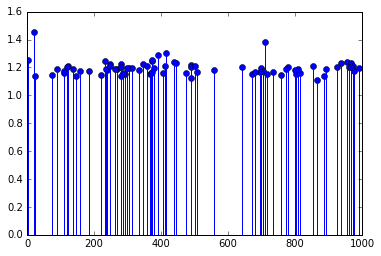

In [45]:
import matplotlib.pyplot as plt
plt.stem(params[:,2],loss[:])
# plt.xscale('log')
plt.show()

In [51]:
trials.trials[0].values()

[datetime.datetime(2018, 3, 17, 19, 42, 16, 844000),
 datetime.datetime(2018, 3, 17, 19, 37, 23, 626000),
 {'cmd': ('domain_attachment', 'FMinIter_Domain'),
  'idxs': {'lr': [0], 'num_dense1': [0], 'num_dense2': [0]},
  'tid': 0,
  'vals': {'lr': [-4.598455840371244],
   'num_dense1': [1546],
   'num_dense2': [976]},
  'workdir': None},
 2,
 0,
 None,
 0,
 {'loss': 1.1770314507653343, 'status': 'ok'},
 None,
 None]